Preparing paper figures for Vedolizumab response

Here are info about the data frame used for the systematic evaluation

In [12]:
import pandas as pd
import seaborn as sns

exec(open("../ML_IterativeRun_HelperFuntionsUpdated").read())

rc_ticks = {
    "figure.figsize": (1.5, 1.2),
    "text.usetex": False,
    "font.size": 8,
    "legend.fontsize":4,
    "legend.title_fontsize":4,
    "xtick.labelsize":6,
    "ytick.labelsize": 6,
    "axes.labelsize":8,
    "axes.titlesize":8,
    "lines.linewidth": 0.5,
    "axes.linewidth": 0.4,
    "lines.markersize": 3,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.5,
    "xtick.major.pad": 1,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.pad": 1,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.5,
    "ytick.major.pad": 1,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.pad": 1,
    "axes.labelpad": 1,
    "axes.titlepad": 1
}
sns.set_theme(context="talk", style="ticks", rc=rc_ticks)

clinicaliloc = range(12, 14)
cytof_freiloc = range(22, 38)
cytof_totaliloc = range(38, 54)
cytof_totalAbiloc = range(55, 70)
cytof_Abiloc = range(71, 87)
facsiloc = range(163, 193)
olinikiloc = range(87, 161)

metadata = pd.read_csv("../Metadata_file.csv", sep = ';', index_col = 0, decimal = ',')

def run_auc(X, X_scaler, y):
    print("The number of patients:", len(y), "\n================================================")
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats = 5 ,random_state=36851234)
    # initiate all the empty variables 2 be filled
    tprs = []
    aucs = []
    data = pd.DataFrame([])
    y_true, y_pred_train, y_auc_test = list(), list(), list()
    mean_fpr = np.linspace(0, 1, 100)
    # ----------------------------------------------------------------------------

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        # fit the classifier
        classifier = LogisticRegression()
        classifier.fit(X_scaler[train, :], y.iloc[train])
        # get training prediction
        yhat_train = classifier.predict(X_scaler[train, :])
        # get recall and store
        y_pred_train.append(roc_auc_score(y.iloc[train], yhat_train))
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_scaler[test, :],
            y.iloc[test],drop_intermediate = False,
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    #ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    #plt.show()

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = stats.sem(aucs)
    return (mean_fpr, mean_tpr, mean_auc, std_auc)


def get_input_data(data, what2choose, treatment_or_response):
    data_frame = data[(what2choose+ ["Response"])]

    if treatment_or_response == "response":
        data_frame['Response_bin'] = np.where(data_frame['Response'] == "R", 1, 0)
    elif treatment_or_response == "treatment":
        data_frame['Response'] = data['timepoint']
        data_frame.dropna(axis=0, how='any', inplace=True)
        data_frame_subset =data_frame
        data_frame_subset['Response_bin'] = np.where(data_frame_subset['Response'] == 3, 1, 0)
    data_frame_subset = data_frame.drop(columns='Response')

    X = data_frame_subset.drop('Response_bin', axis=1)
    y = data_frame_subset.Response_bin
    X_scaler = scaler.fit_transform(X)
    X_scaler = scaler.transform(X)

    mean_fpr, mean_tpr, mean_auc, std_auc = run_auc(X, X_scaler, y)
    return (mean_fpr, mean_tpr, mean_auc, std_auc)

from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score, f1_score
metadata = pd.read_csv("../Metadata_file.csv", sep=';', index_col=0, decimal=',')

# Filter for timepoint 1 and VDZ treatment
only_timepoint_one = metadata[metadata["timepoint"] == 1]
only_timepoint_one_filtered = only_timepoint_one[
    (only_timepoint_one["response"] == "R") | (only_timepoint_one["response"] == "NR")]


# clinicaliloc = [13,14,15,16,17,21]
clinicaliloc = [12, 13, 14, 15, 16, 19]
cytof_freiloc = range(22, 38)
cytof_totaliloc = range(38, 54)
cytof_totalAbiloc = range(54, 70)
cytof_Abiloc = range(71, 87)
facsiloc = range(163, 193)
olinikiloc = range(87, 161)

# Model visualizations

## Single modalities
### Complete feature space

FACS OLINK

           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.61    11.40  4.97        R
P46.1           1.77        25.8      1.82     9.29  6.81        R
The number of patients: 17 


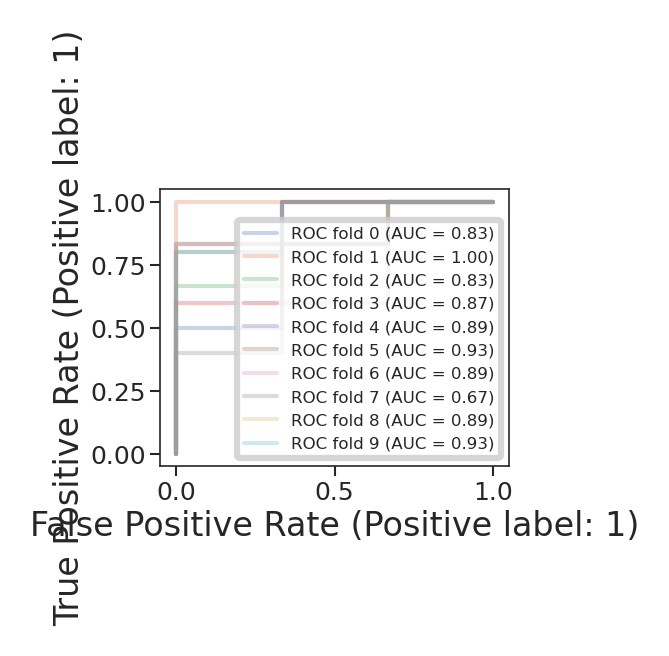

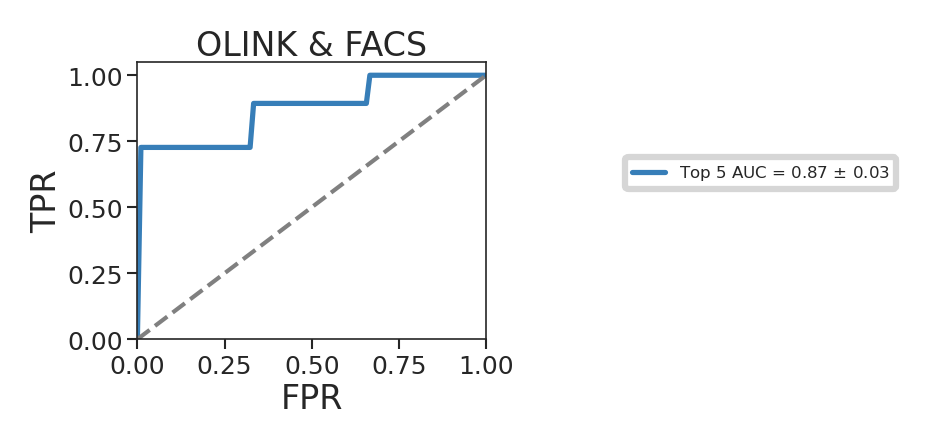

sample_id
P143.1    0
P27.1     1
P46.1     1
P90.1     1
P94.1     0
Name: Response_bin, dtype: int64
[1 1 1 1 0]
Accuracy:0.8


In [12]:
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc]]
selected_features2 = ["Ki67_FACS","CXCR3_FACS","IL4_FACS","B7_FACS","TNF" ]
#selected_features2 = ["Ki67_FACS","IL4_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)

train = train[selected_features2+ ['Response']]
test = test[selected_features2 + ['Response']]
print(test)

mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                               what2choose=selected_features2,
                                                                               treatment_or_response="response")

# -----------------------------------------------------------------------------------------------------
plt.figure()
plt.rcParams['figure.dpi'] = 400
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#377eb8", lw=lw)

plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("OLINK & FACS")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
plt.savefig('AUC_OLINK_FACS.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Check test set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))

del contrast_data, train, test, mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1, X_test,  X_train, y_train, y_test

OLINK FACS CyTOF

           Ki67_FACS  CXCR3_FACS  GPR15_FACS  CXCL6  IL4_FACS Response
sample_id                                                             
P90.1           1.01        13.1        6.32  11.49      1.60        R
P8.1            1.91        11.5        0.92   9.85      1.26        R
P141.1          2.28        11.7        8.18   9.86      1.27       NR
P1.1            0.99        17.1        4.69  11.12      0.58        R
The number of patients: 13 


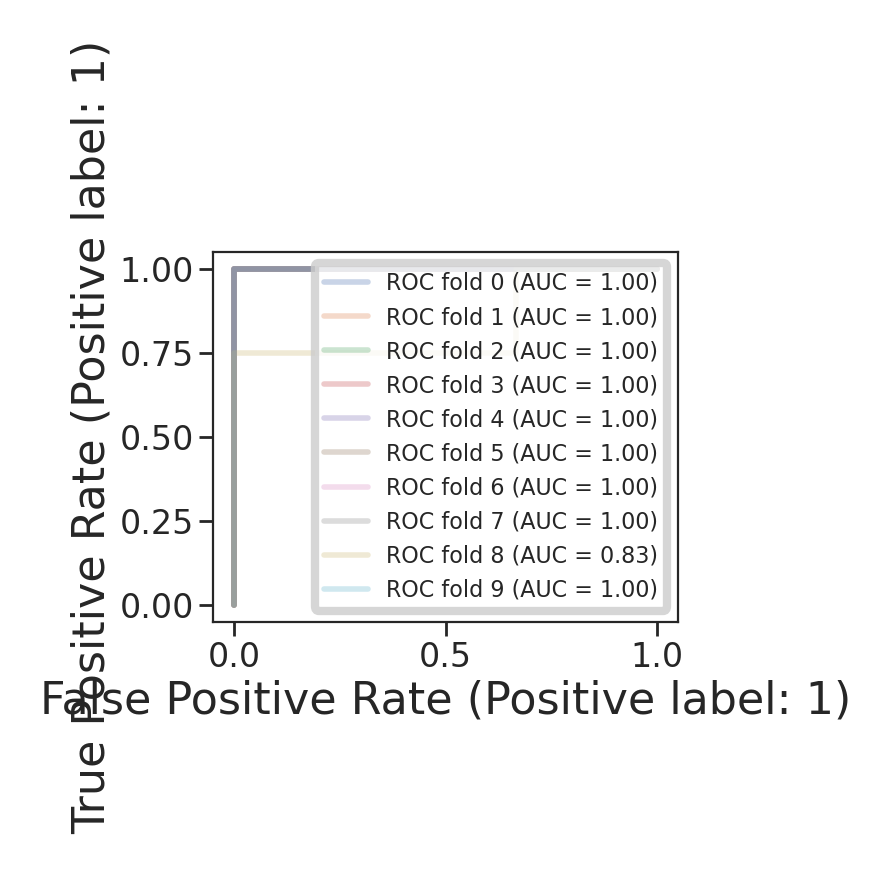

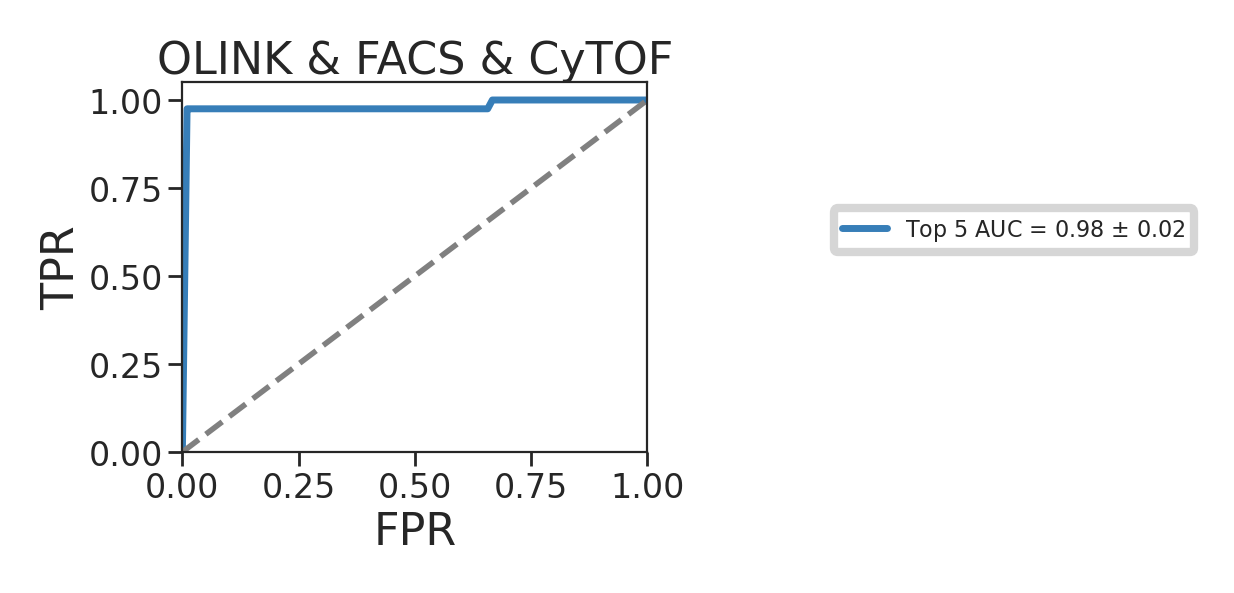

sample_id
P1.1      1
P141.1    0
P8.1      1
P90.1     1
Name: Response_bin, dtype: int64
[1 1 1 1]
Accuracy:0.75


In [13]:
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc, cytof_freiloc]]
selected_features2 = ["Ki67_FACS","CXCR3_FACS","GPR15_FACS","CXCL6","IL4_FACS" ]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)

train = train[selected_features2+ ['Response']]
test = test[selected_features2 + ['Response']]
print(test)

mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                               what2choose=selected_features2,
                                                                               treatment_or_response="response")


plt.figure()
plt.rcParams['figure.dpi'] = 300
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#377eb8", lw=lw)

plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("OLINK & FACS & CyTOF")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
plt.savefig('AUC_OLINK_FACS_CyTOF.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Check test set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))

del contrast_data, train, test, mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1, X_test,  X_train, y_train, y_test

FACS CYTOFab

           IFNg_FACS  Ki67_FACS  CXCR3_FACS  Tbet_FACS  Treg_FACS Response
sample_id                                                                 
P7.1            16.6       4.30        18.8       33.4       3.39       NR
P29.1           27.1       2.86        16.0       37.2       2.90        R
P5.1            15.8       1.87        25.1       14.1       2.72        R
P90.1           26.6       1.01        13.1       23.5       2.47        R
P3.1            31.7       3.90        28.1       27.5       2.55       NR
The number of patients: 19 


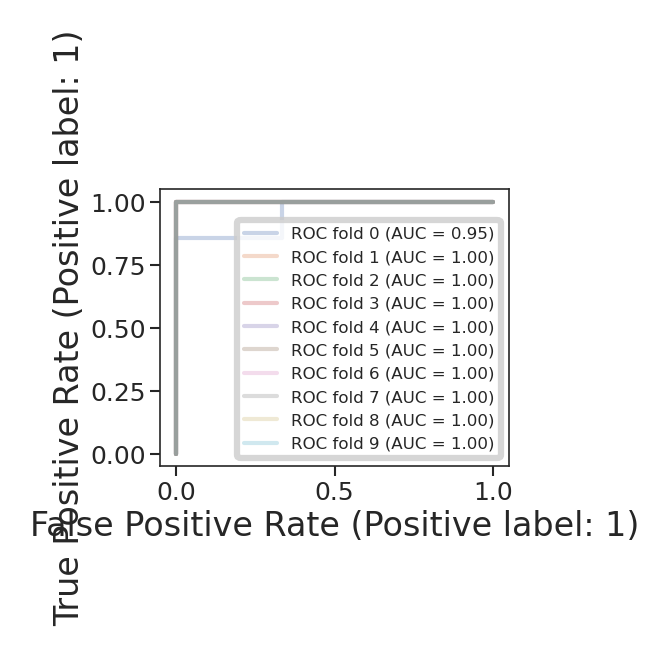

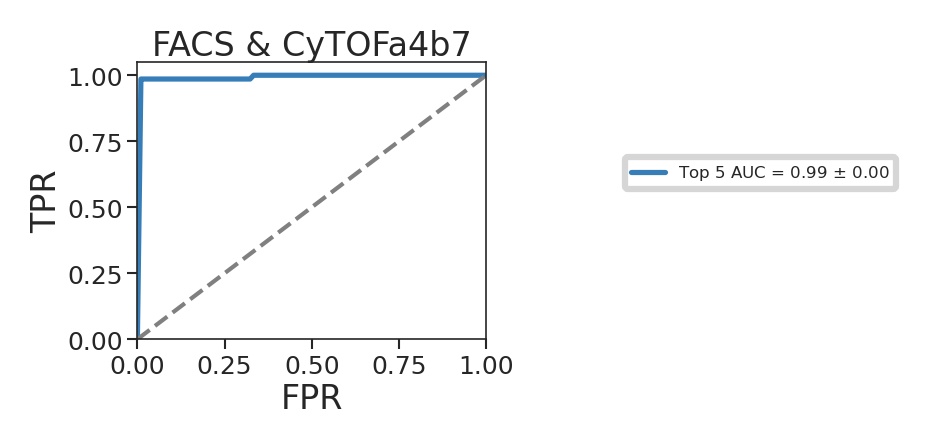

sample_id
P29.1    1
P3.1     0
P5.1     1
P7.1     0
P90.1    1
Name: Response_bin, dtype: int64
[1 1 0 1 1]
Accuracy:0.4


In [14]:
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, cytof_Abiloc]]

selected_features2 = ["IFNg_FACS","Ki67_FACS","CXCR3_FACS","Tbet_FACS","Treg_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=5)

train = train[selected_features2+ ['Response']]
test = test[selected_features2 + ['Response']]
print(test)

mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                               what2choose=selected_features2,
                                                                               treatment_or_response="response")


plt.figure()
plt.rcParams['figure.dpi'] = 300
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#377eb8", lw=lw)

plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FACS & CyTOFa4b7")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
plt.savefig('AUC_FACS_CyTOFab.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))

del contrast_data, train, test, mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1, X_test,  X_train, y_train, y_test


           NK cells  CXCR3_FACS  IFNg_FACS  Ki67_FACS  CD103_FACS Response
sample_id                                                                 
P7.1           1.16        18.8       16.6       4.30        0.52       NR
P22.1          5.16        17.2       27.0       3.71        0.53        R
P81.1         13.68        27.1       31.6       1.94        1.27        R
P92.1          0.74        14.9       24.7       3.42        0.36        R
The number of patients: 15 


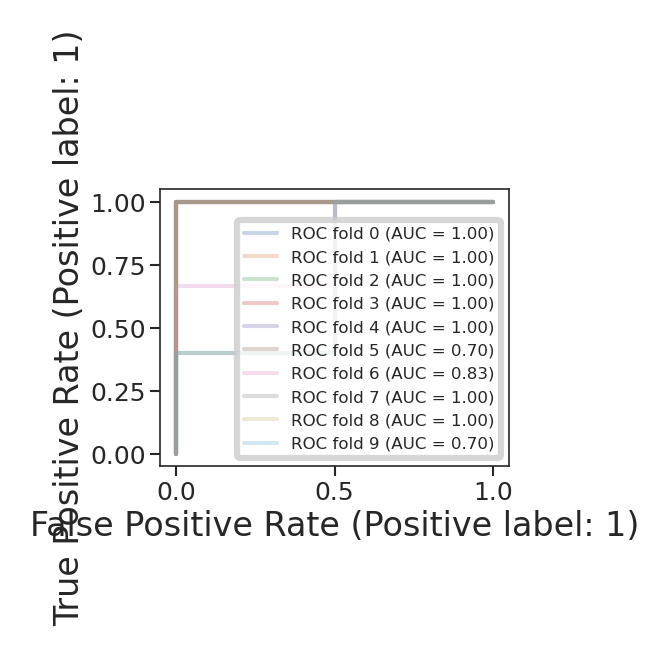

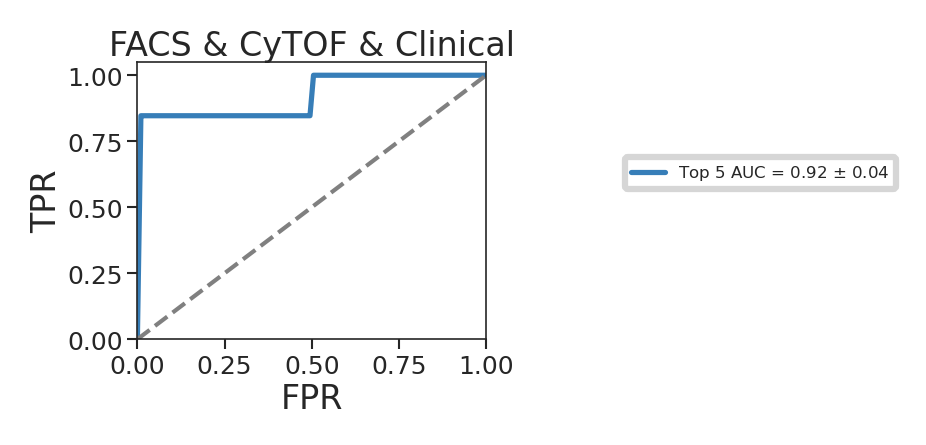

sample_id
P22.1    1
P7.1     0
P81.1    1
P92.1    1
Name: Response_bin, dtype: int64
[1 1 1 1]
Accuracy:0.75


In [15]:
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, clinicaliloc, cytof_freiloc]]
selected_features2 = ["NK cells","CXCR3_FACS","IFNg_FACS","Ki67_FACS","CD103_FACS" ]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)

train = train[selected_features2+ ['Response']]
test = test[selected_features2 + ['Response']]
print(test)

mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                               what2choose=selected_features2,
                                                                               treatment_or_response="response")

plt.figure()
plt.rcParams['figure.dpi'] = 300
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#377eb8", lw=lw)

plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FACS & CyTOF & Clinical")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
plt.savefig('AUC_FACS_CyTOF_Clinical.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))

del contrast_data, train, test, mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1, X_test,  X_train, y_train, y_test

The number of patients: 26 
The number of patients: 26 


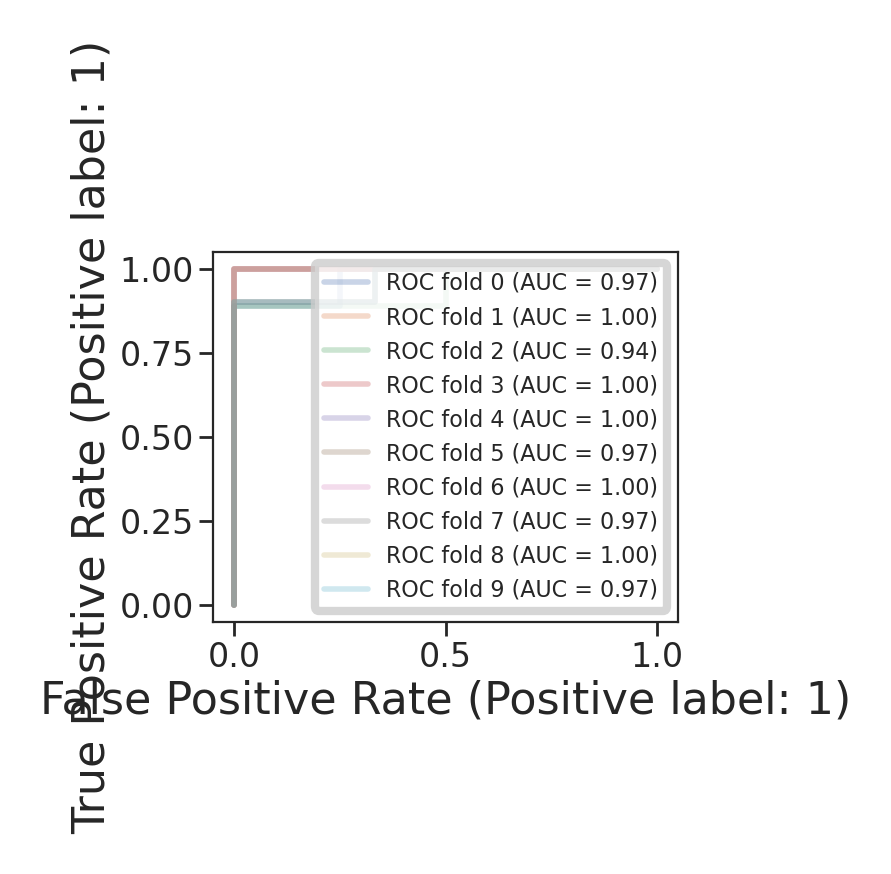

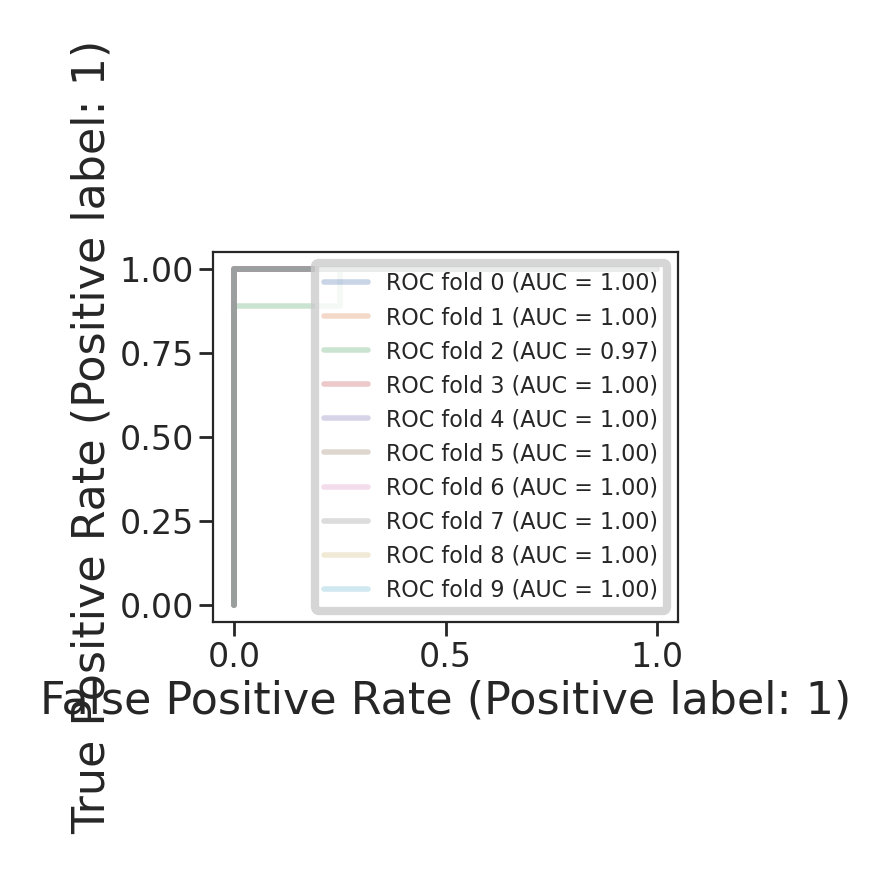

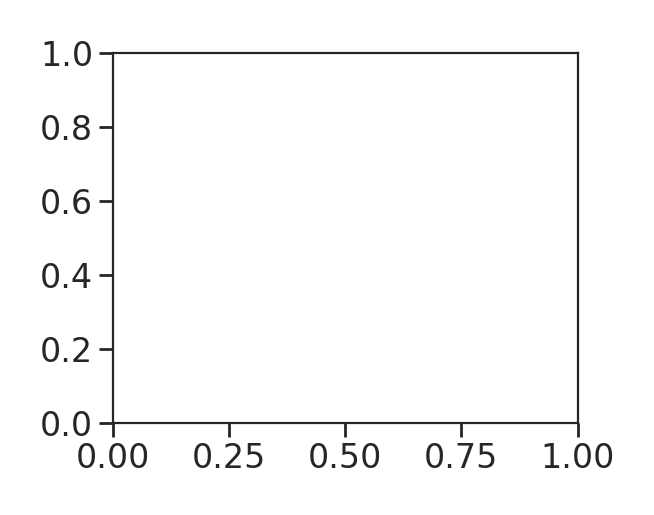

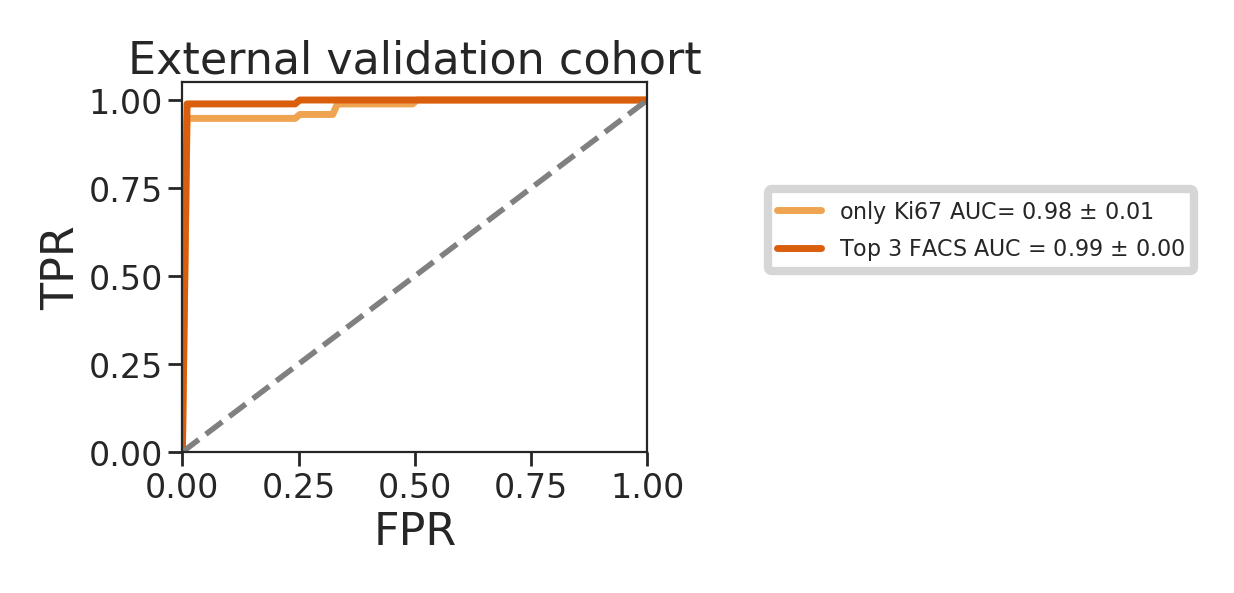

In [16]:
#Combined AUC with selected marker combinations

           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.61    11.40  4.97        R
P46.1           1.77        25.8      1.82     9.29  6.81        R
The number of patients: 17 
           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.61    11.40  4.97        R
P46.1           1.77        25.8      1.82     9.29  6.81        R
The number of patients: 17 
      

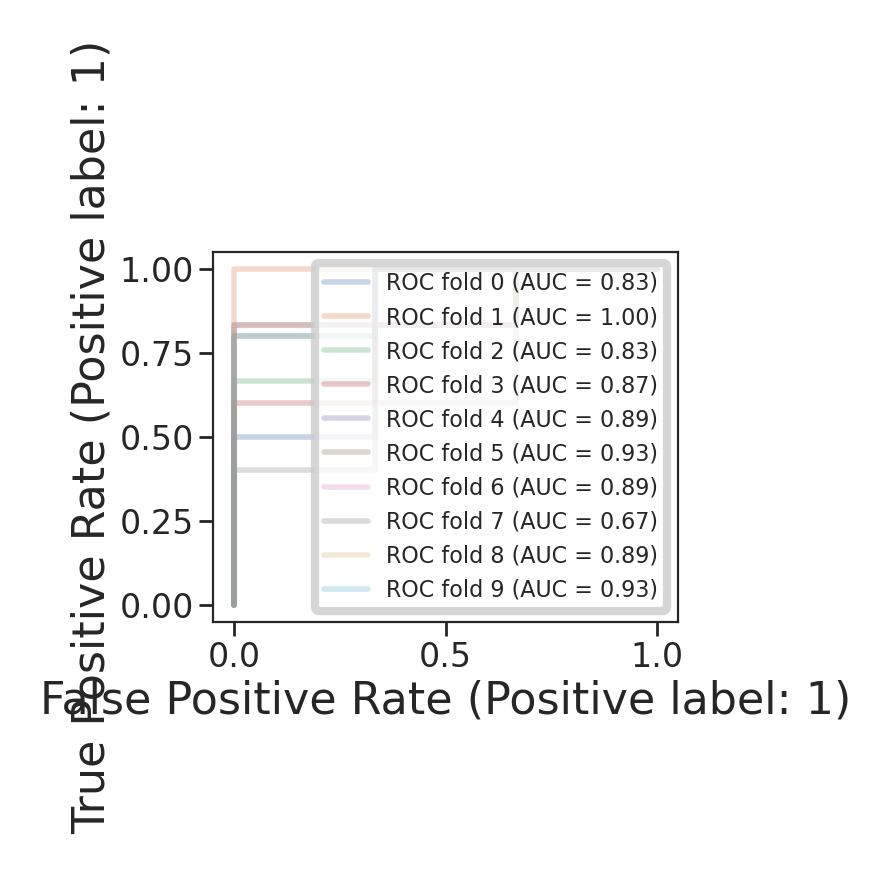

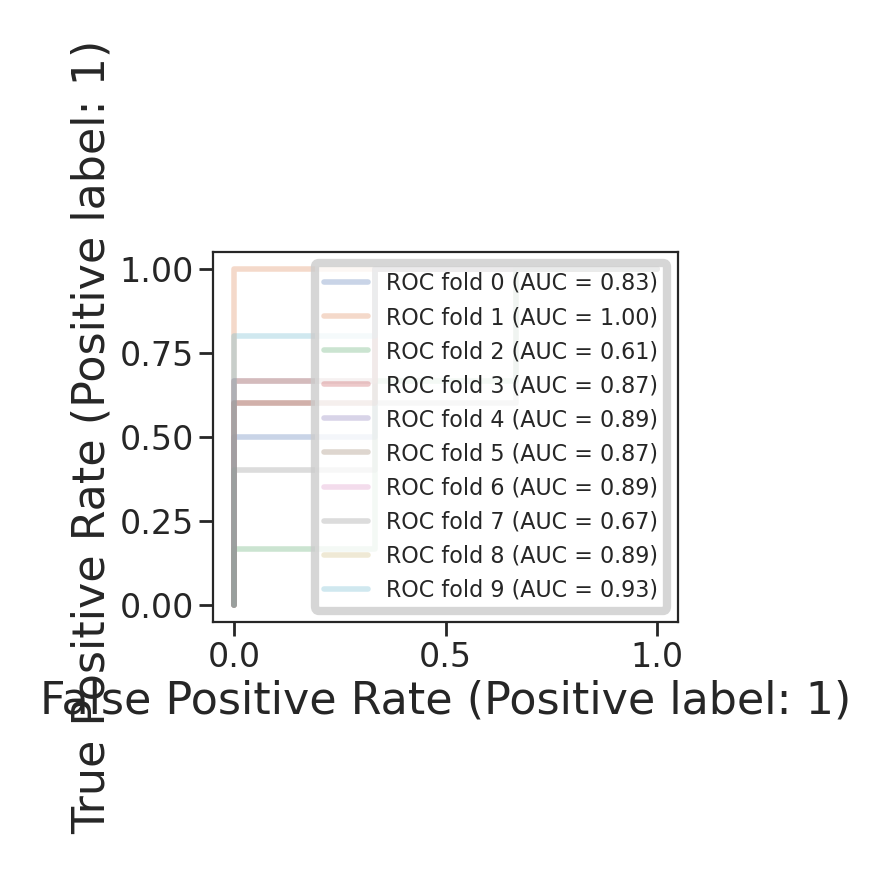

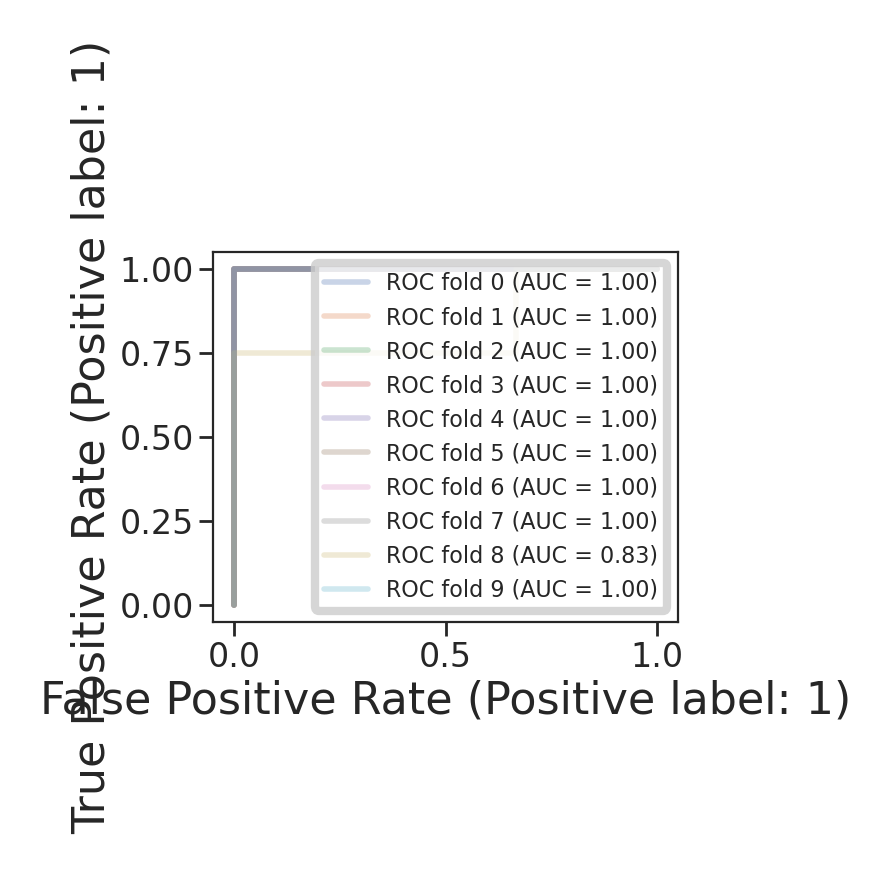

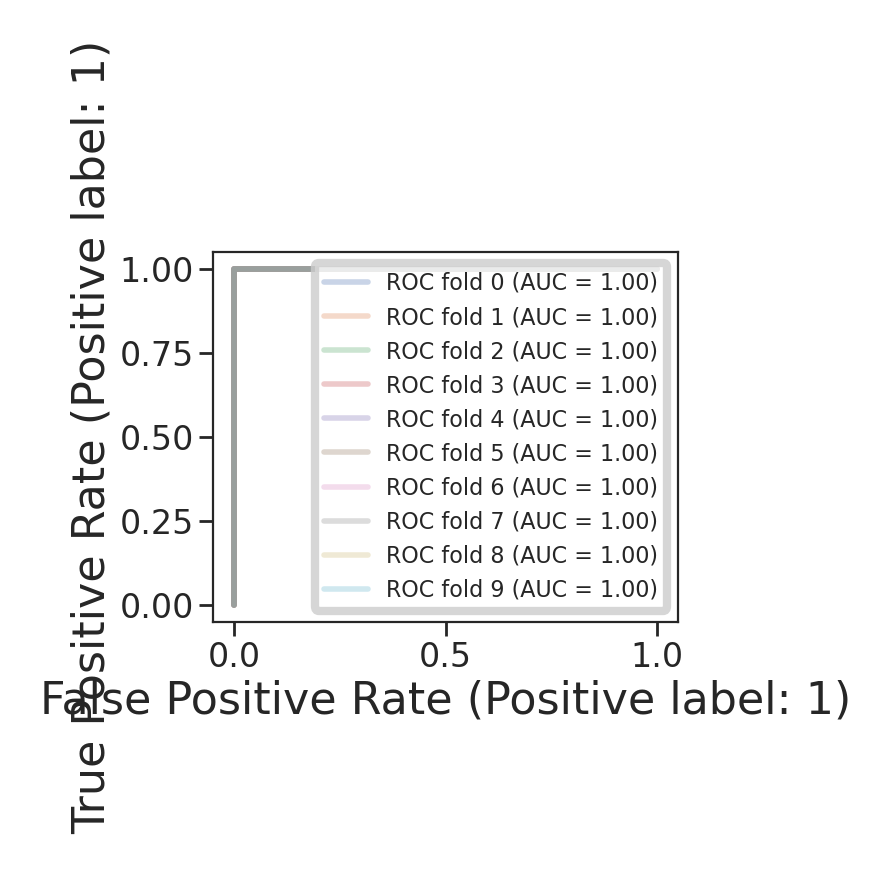

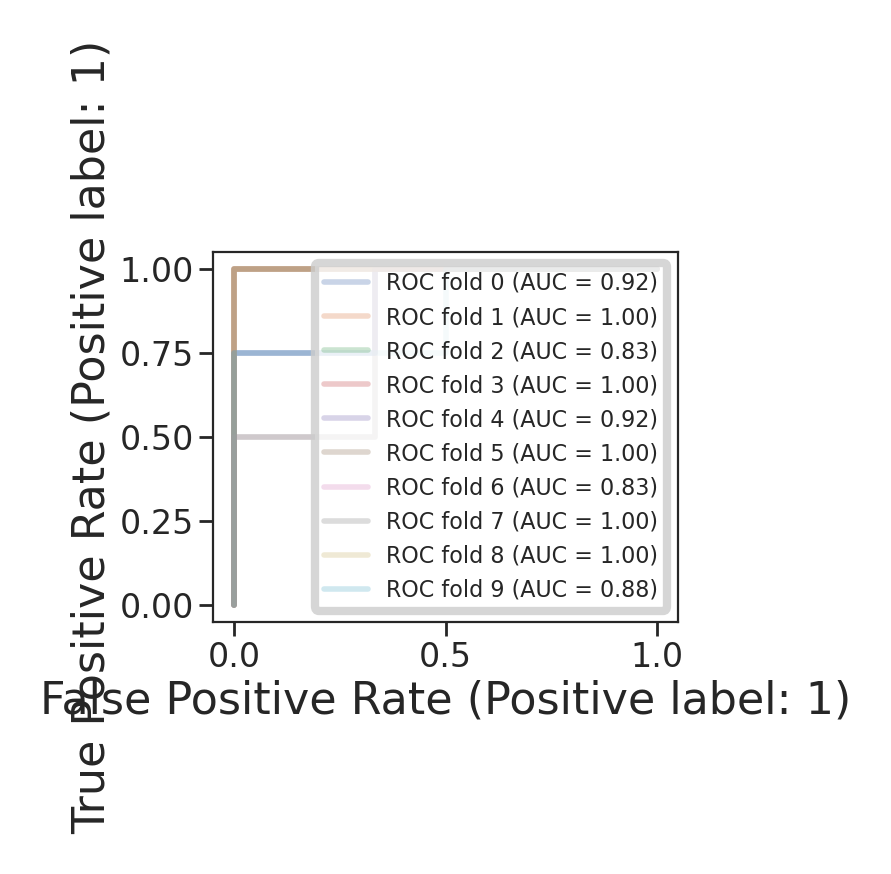

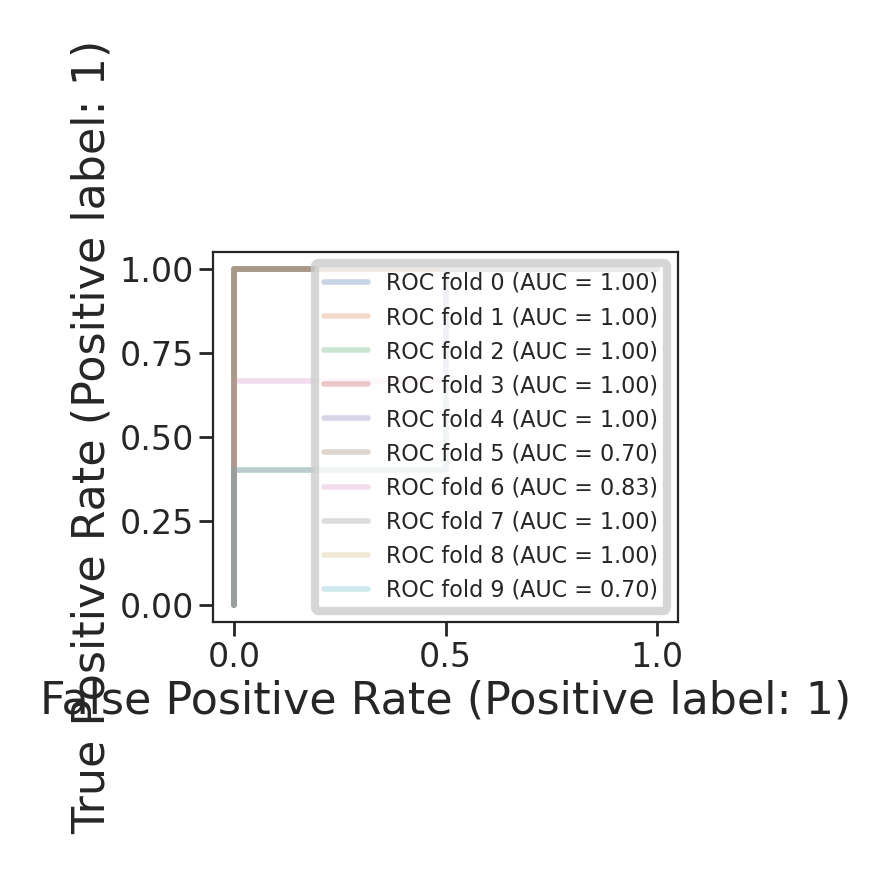

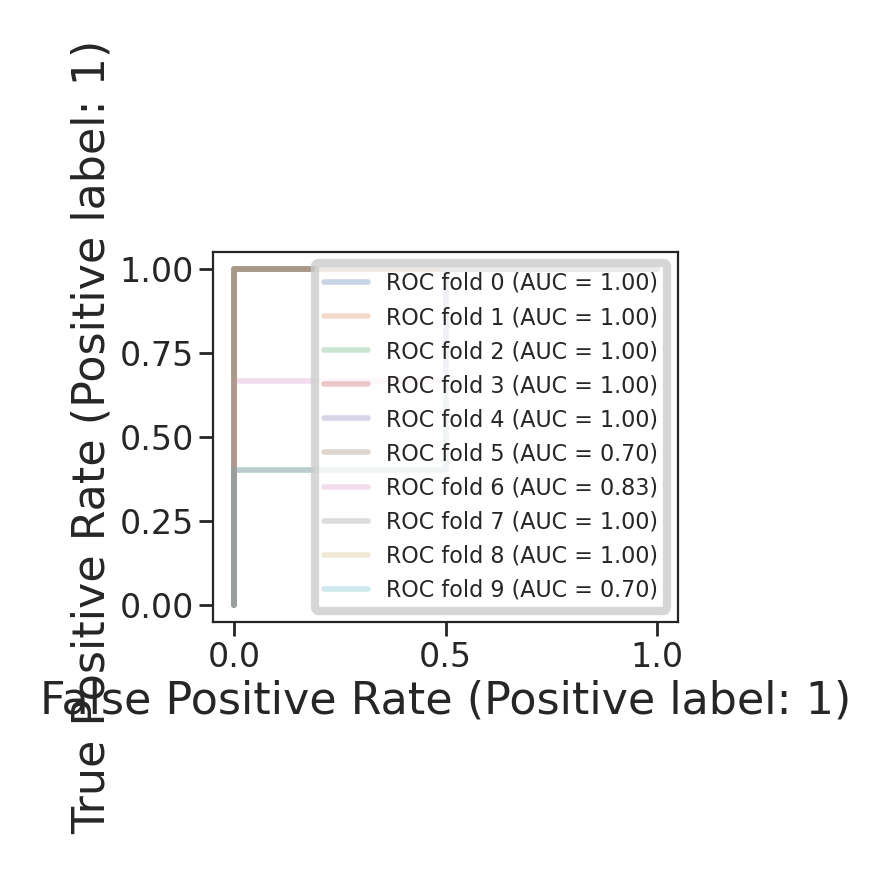

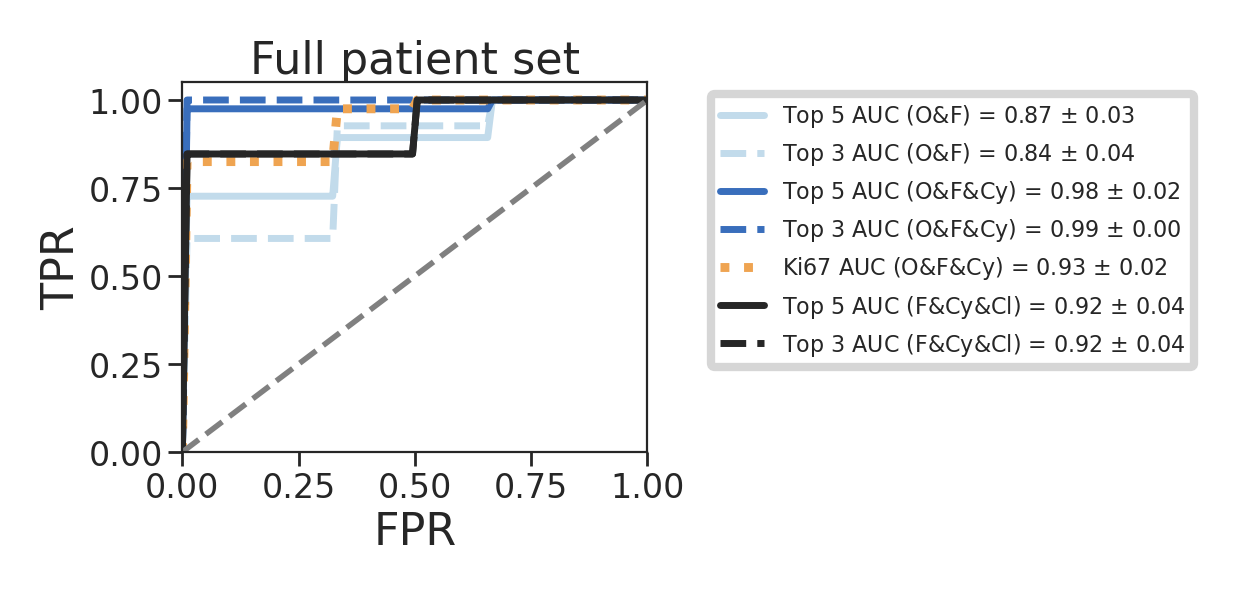

In [7]:
selected_patients = ['P1.1', 'P105.1', 'P141.1', 'P15.1', 'P17.1', 'P22.1', 'P27.1', 'P28.1', 'P37.1', 'P4.1', 'P5.1', 'P7.1', 'P8.1', 'P90.1', 'P92.1']


# Olink FACS

# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc]]

selected_features2 = ["Ki67_FACS", "CXCR3_FACS", "IL4_FACS", "B7_FACS", "TNF"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
#train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

selected_features3 = ["Ki67_FACS", "CXCR3_FACS", "IL4_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
#train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model1_less, mean_tpr_model1_less, mean_auc_model1_less, std_auc_model1_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")


# Olink FACS CyTOF
# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc, cytof_freiloc]]
selected_features2 = ["Ki67_FACS", "CXCR3_FACS", "GPR15_FACS", "CXCL6", "IL4_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
#train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model2, mean_tpr_model2, mean_auc_model2, std_auc_model2 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

selected_features3 = ["Ki67_FACS", "CXCR3_FACS", "GPR15_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
#train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model2_less, mean_tpr_model2_less, mean_auc_model2_less, std_auc_model2_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")

selected_features4 = ["Ki67_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
#train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model_2ki, mean_tpr_model_2ki, mean_auc_model_2ki, std_auc_model_2ki =get_input_data(data=train,
                                                                                what2choose=selected_features4,
                                                                                   treatment_or_response="response")

# Clinical FACS CyTOF
# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, clinicaliloc, cytof_freiloc]]
selected_features2 = ["NK cells", "CXCR3_FACS", "Ki67_FACS", "IFNg_FACS", "CD103_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
#train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model3, mean_tpr_model3, mean_auc_model3, std_auc_model3 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

selected_features3 = ["NK cells", "CXCR3_FACS", "Ki67_FACS", "IFNg_FACS", "CD103_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
#train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model3_less, mean_tpr_model3_less, mean_auc_model3_less, std_auc_model3_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")



# -----------------------------------------------------------------------------------------------------
plt.figure()
plt.rcParams['figure.dpi'] = 400
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#c2dbebff", lw=lw)
plt.plot(mean_fpr_model1_less, mean_tpr_model1_less,
         label=r"Top 3 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model1_less, std_auc_model1_less),
         color="#c2dbebff", lw=lw, linestyle='--')



plt.plot(mean_fpr_model2, mean_tpr_model2,
         label=r"Top 5 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model2, std_auc_model2),
         color="#396ebcff", lw=lw)
plt.plot(mean_fpr_model2_less, mean_tpr_model2_less,
         label=r"Top 3 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model2_less, std_auc_model2_less),
         color="#396ebcff", lw=lw, linestyle='--')

plt.plot(mean_fpr_model_2ki, mean_tpr_model_2ki,
         label=r"Ki67 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model_2ki, std_auc_model_2ki),
         color="#efa451ff", lw=1.6, linestyle='dotted')

plt.plot(mean_fpr_model3, mean_tpr_model3,
         label=r"Top 5 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model3, std_auc_model3),
         color="#262626ff", lw=lw)
plt.plot(mean_fpr_model3_less, mean_tpr_model3_less,
         label=r"Top 3 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model3_less, std_auc_model3_less),
         color="#262626ff", lw=lw, linestyle='--')





plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Full patient set")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
plt.savefig('Full_patients_3Models.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# Combined plots with selected marker combinations but on completely profiled patients

           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.61    11.40  4.97        R
P46.1           1.77        25.8      1.82     9.29  6.81        R
The number of patients: 11 
           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.61    11.40  4.97        R
P46.1           1.77        25.8      1.82     9.29  6.81        R
The number of patients: 11 
      

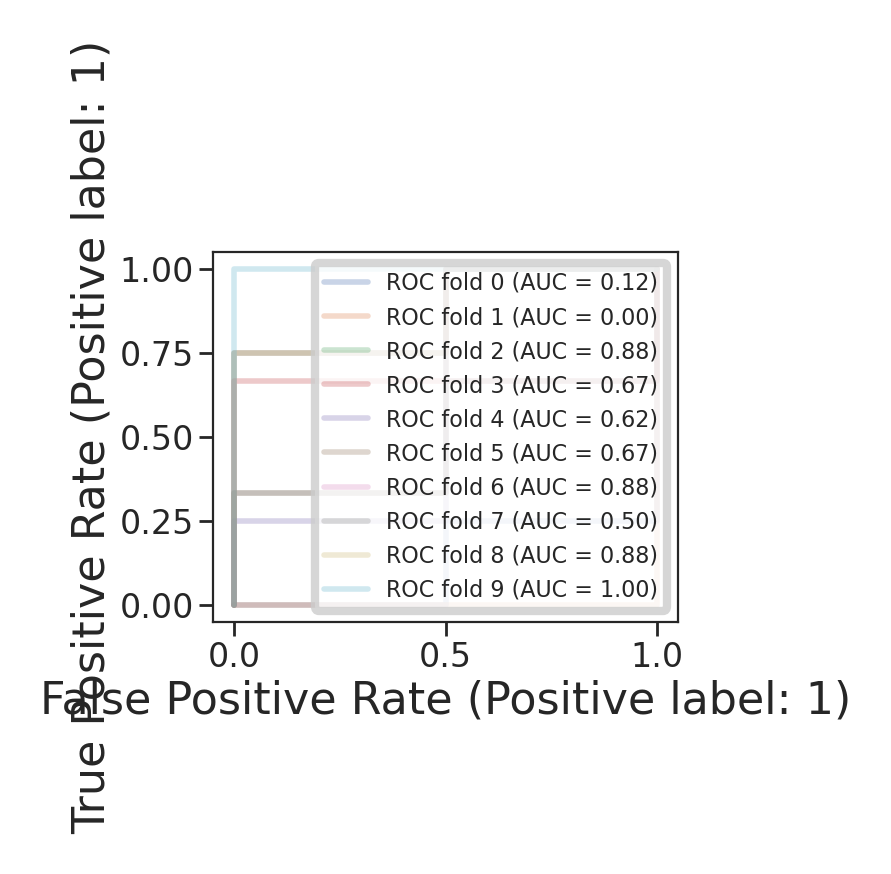

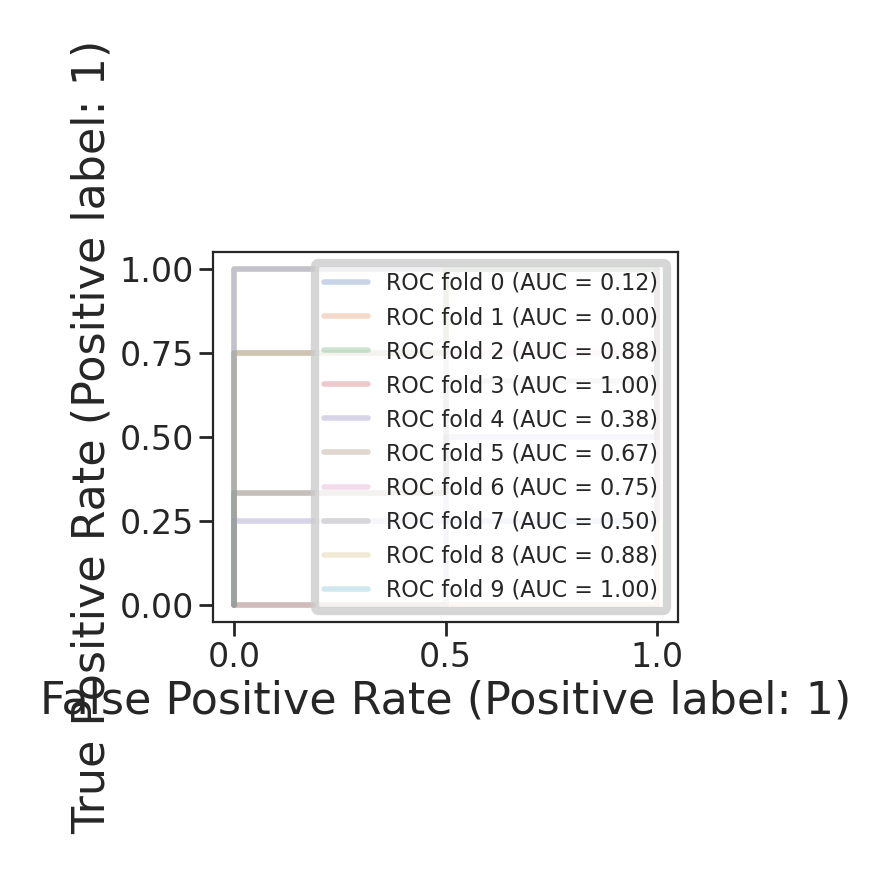

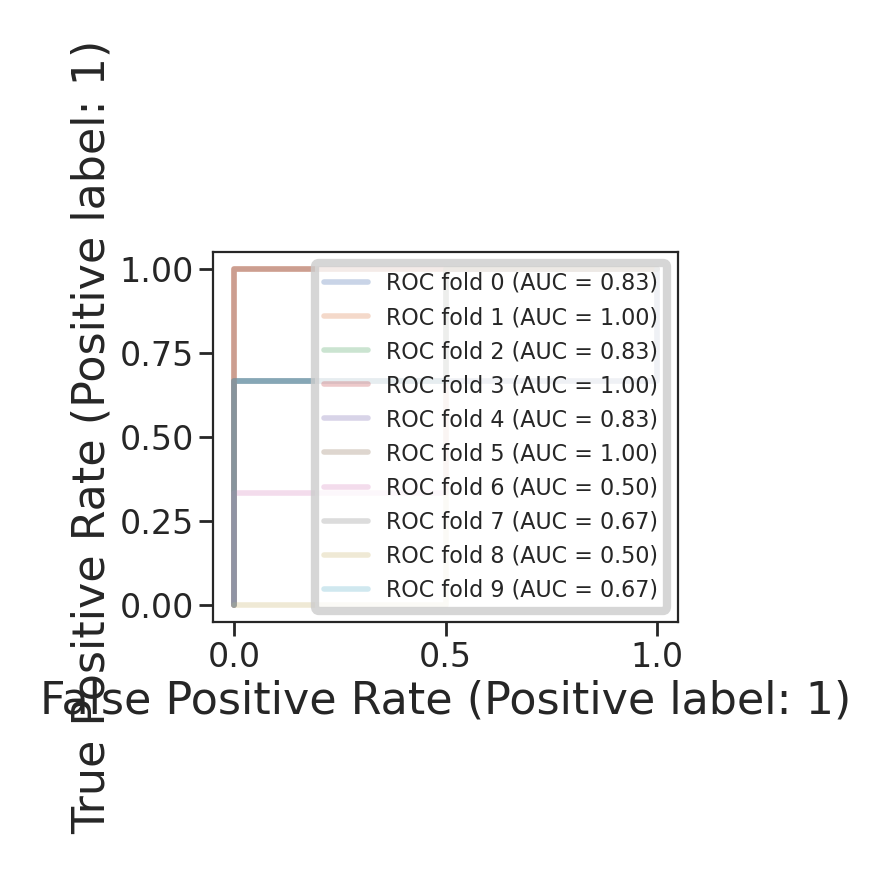

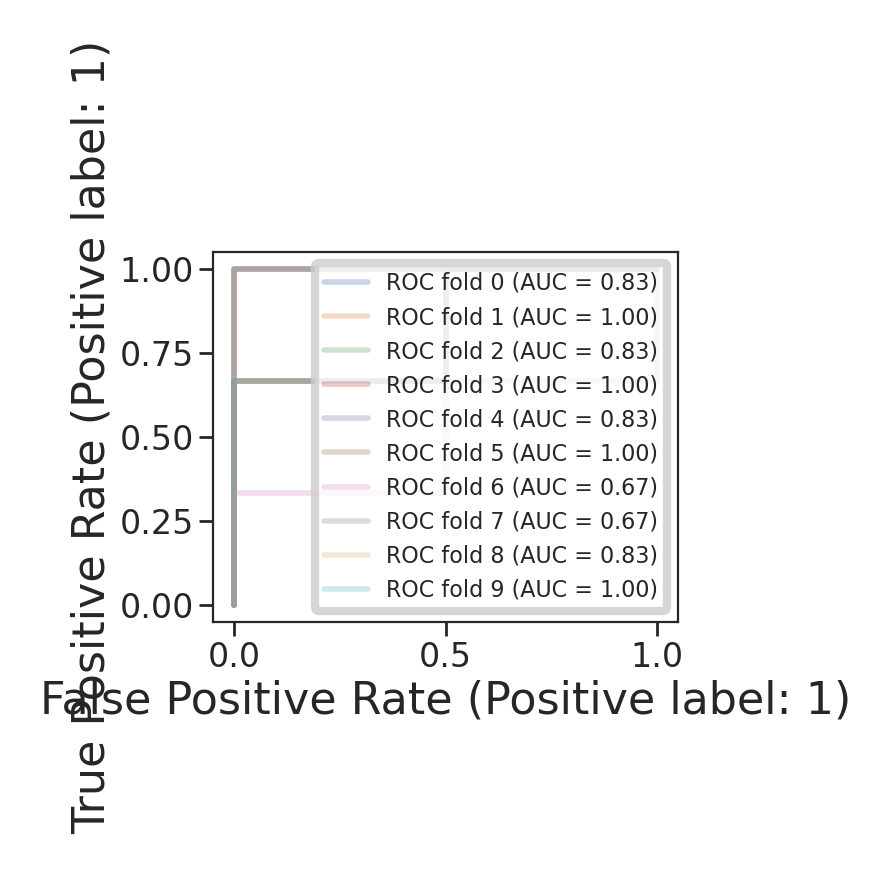

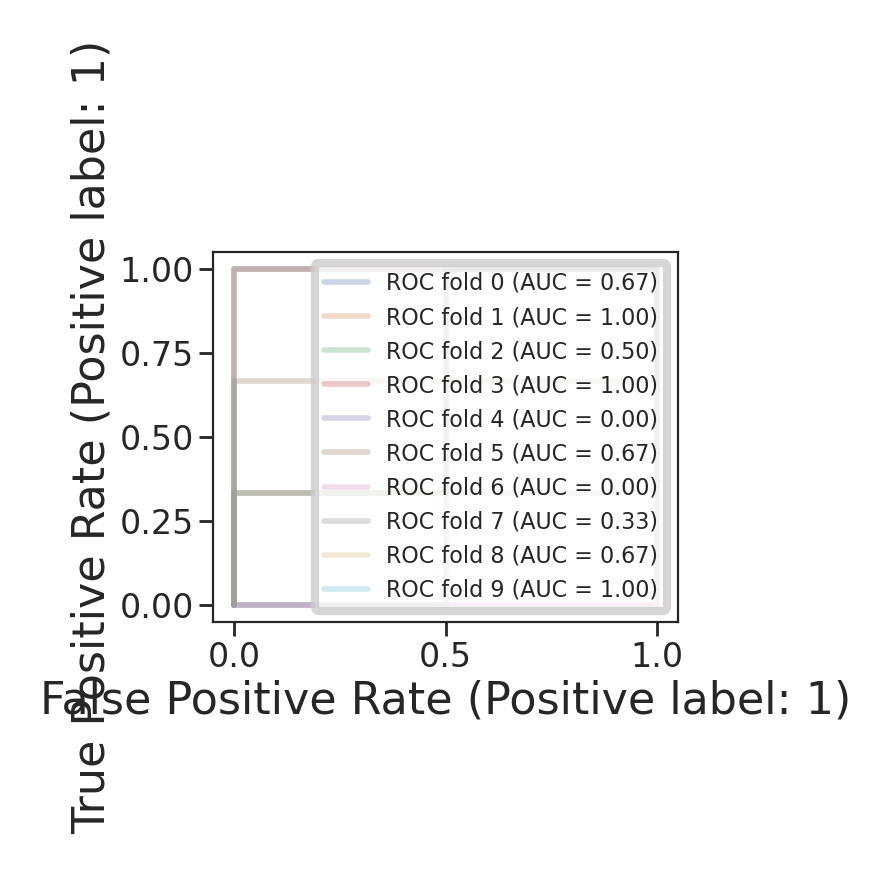

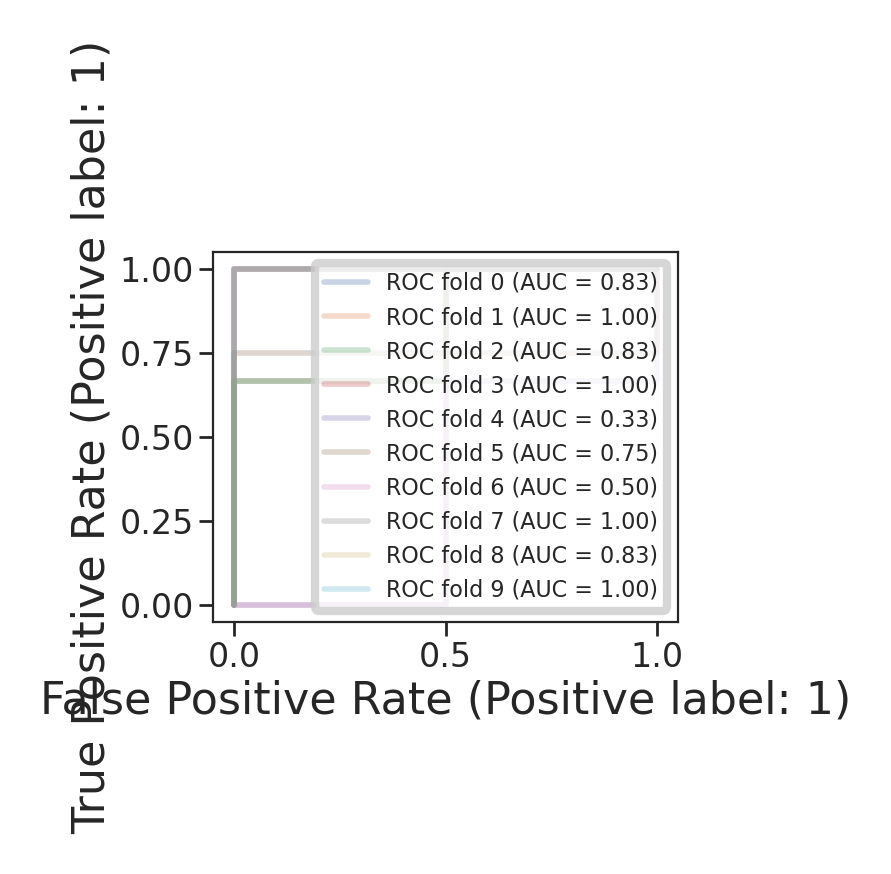

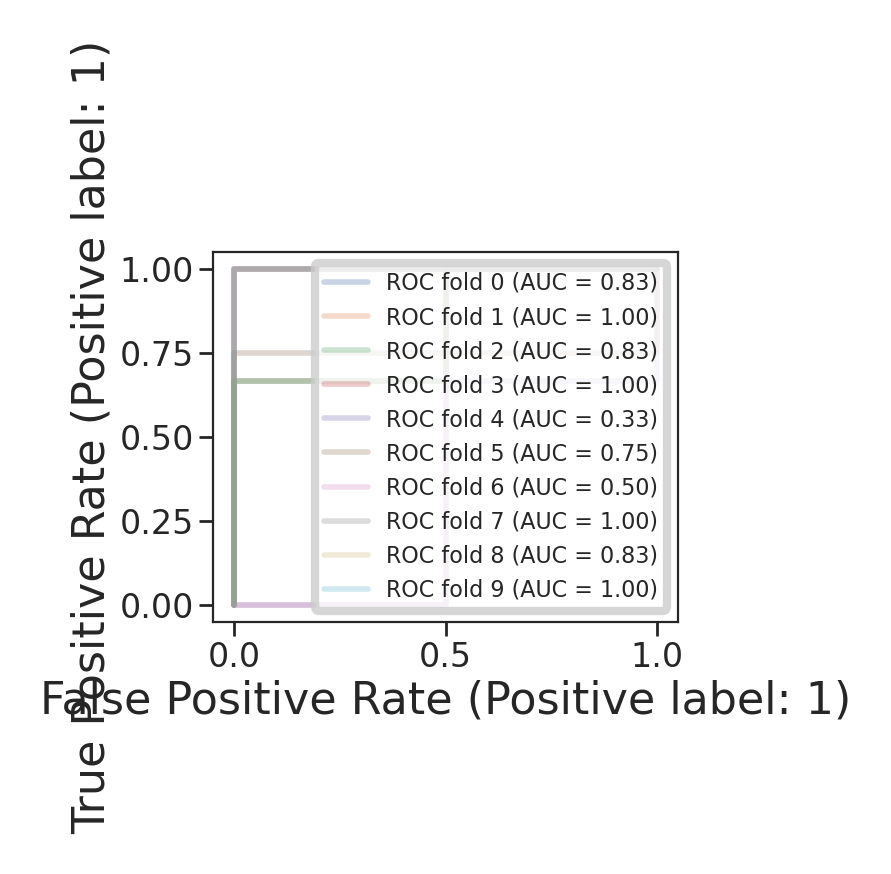

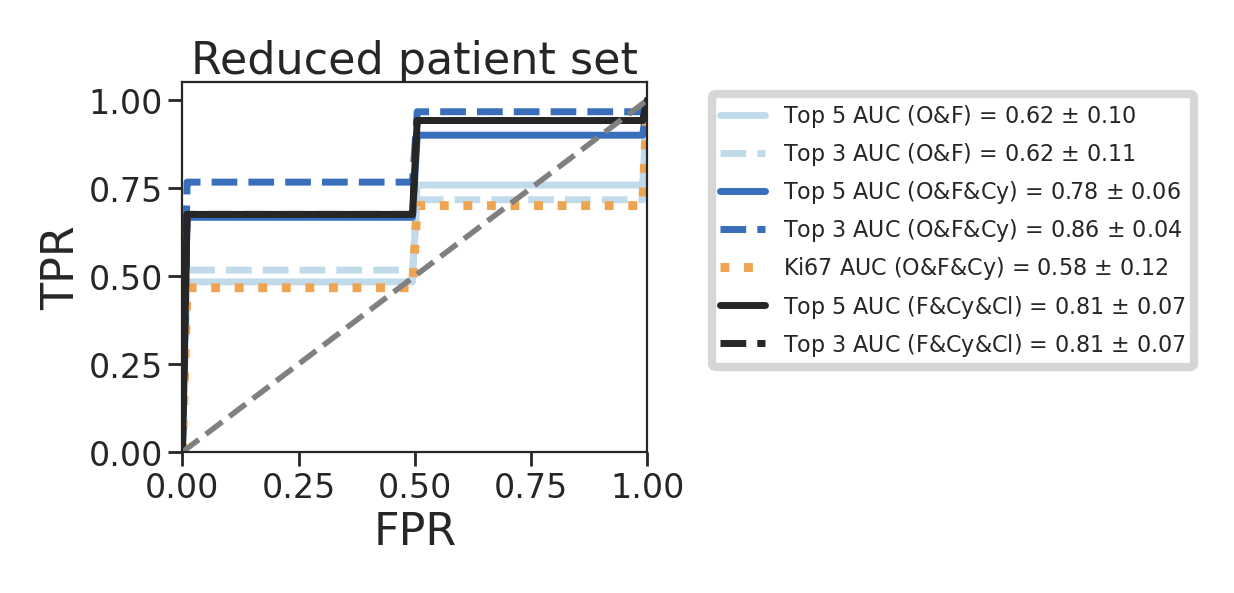

In [8]:
#np.random.seed(42)
#contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc, cytof_freiloc]]


#selected_patients_df = contrast_data.sample(n=15, replace=True)
#selected_patients = selected_patients_df.index.tolist()
selected_patients = ['P1.1', 'P105.1', 'P141.1', 'P15.1', 'P17.1', 'P22.1', 'P27.1', 'P28.1', 'P37.1', 'P4.1', 'P5.1', 'P7.1', 'P8.1', 'P90.1', 'P92.1']

# Olink FACS

# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc]]

selected_features2 = ["Ki67_FACS", "CXCR3_FACS", "IL4_FACS", "B7_FACS", "TNF"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

selected_features3 = ["Ki67_FACS", "CXCR3_FACS", "IL4_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model1_less, mean_tpr_model1_less, mean_auc_model1_less, std_auc_model1_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")


# Olink FACS CyTOF
# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc, cytof_freiloc]]
selected_features2 = ["Ki67_FACS", "CXCR3_FACS", "GPR15_FACS", "CXCL6", "IL4_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model2, mean_tpr_model2, mean_auc_model2, std_auc_model2 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

selected_features3 = ["Ki67_FACS", "CXCR3_FACS", "GPR15_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model2_less, mean_tpr_model2_less, mean_auc_model2_less, std_auc_model2_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")
selected_features4 = ["Ki67_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model_2ki, mean_tpr_model_2ki, mean_auc_model_2ki, std_auc_model_2ki =get_input_data(data=train,
                                                                                what2choose=selected_features4,
                                                                                   treatment_or_response="response")

# Clinical FACS CyTOF
# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, clinicaliloc, cytof_freiloc]]
selected_features2 = ["NK cells", "CXCR3_FACS", "Ki67_FACS", "IFNg_FACS", "CD103_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model3, mean_tpr_model3, mean_auc_model3, std_auc_model3 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

selected_features3 = ["NK cells", "CXCR3_FACS", "Ki67_FACS", "IFNg_FACS", "CD103_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model3_less, mean_tpr_model3_less, mean_auc_model3_less, std_auc_model3_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")



# -----------------------------------------------------------------------------------------------------
plt.figure()
plt.rcParams['figure.dpi'] = 400
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#c2dbebff", lw=lw)
plt.plot(mean_fpr_model1_less, mean_tpr_model1_less,
         label=r"Top 3 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model1_less, std_auc_model1_less),
         color="#c2dbebff", lw=lw, linestyle='--')



plt.plot(mean_fpr_model2, mean_tpr_model2,
         label=r"Top 5 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model2, std_auc_model2),
         color="#396ebcff", lw=lw)
plt.plot(mean_fpr_model2_less, mean_tpr_model2_less,
         label=r"Top 3 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model2_less, std_auc_model2_less),
         color="#396ebcff", lw=lw, linestyle='--')

plt.plot(mean_fpr_model_2ki, mean_tpr_model_2ki,
         label=r"Ki67 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model_2ki, std_auc_model_2ki),
         color="#efa451ff", lw=1.6, linestyle='dotted')

plt.plot(mean_fpr_model3, mean_tpr_model3,
         label=r"Top 5 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model3, std_auc_model3),
         color="#262626ff", lw=lw)
plt.plot(mean_fpr_model3_less, mean_tpr_model3_less,
         label=r"Top 3 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model3_less, std_auc_model3_less),
         color="#262626ff", lw=lw, linestyle='--')


plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Reduced patient set")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
plt.savefig('Red_patients_3Models.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# Combined AUC of selected markers and completely profiled patients but with all combinations

           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.61    11.40  4.97        R
P46.1           1.77        25.8      1.82     9.29  6.81        R
The number of patients: 11 
sample_id
P143.1    0
P27.1     1
P46.1     1
P90.1     1
P94.1     0
Name: Response_bin, dtype: int64
[1 1 1 1 1]
Accuracy:0.6
           Ki67_FACS  CXCR3_FACS  IL4_FACS  B7_FACS   TNF Response
sample_id                                                         
P90.1           1.01        13.1      1.60     8.37  3.89        R
P94.1          10.50        23.5      3.43    11.40  5.00       NR
P143.1          5.25        16.3      0.99    12.50  9.92       NR
P27.1           2.38        22.2      0.

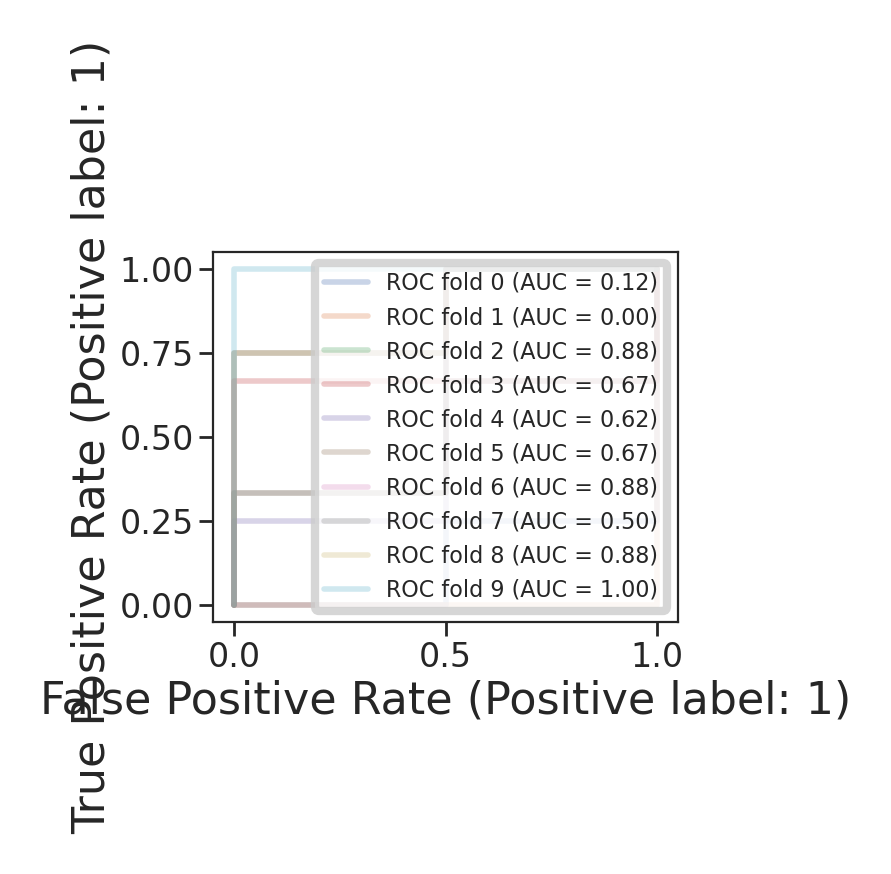

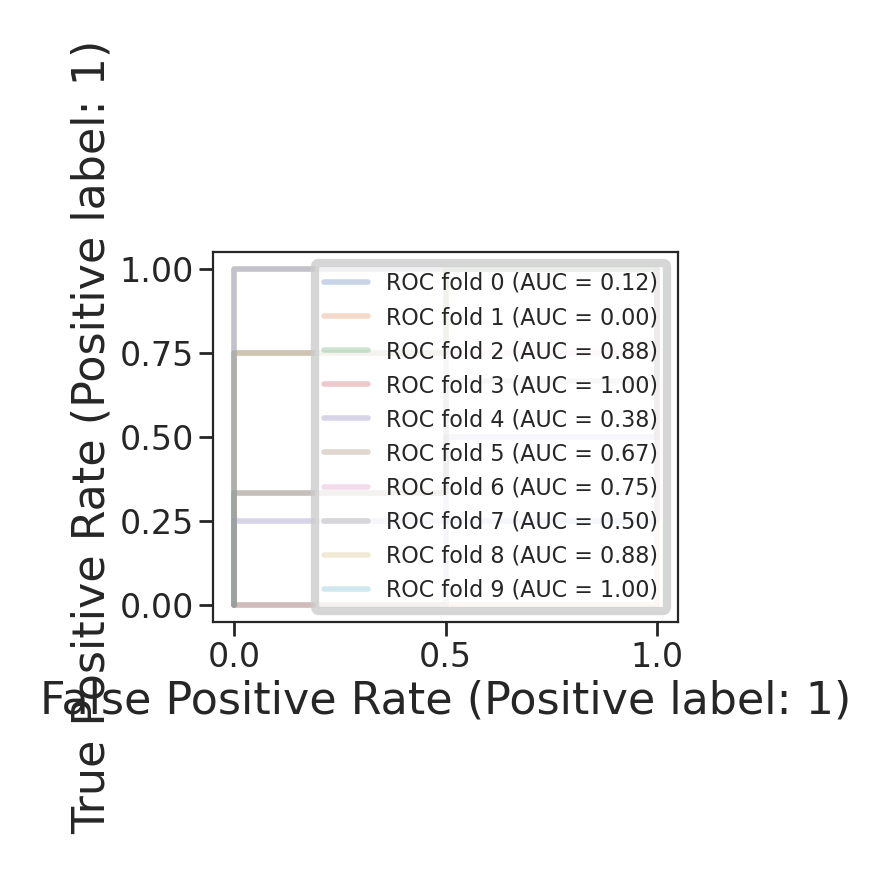

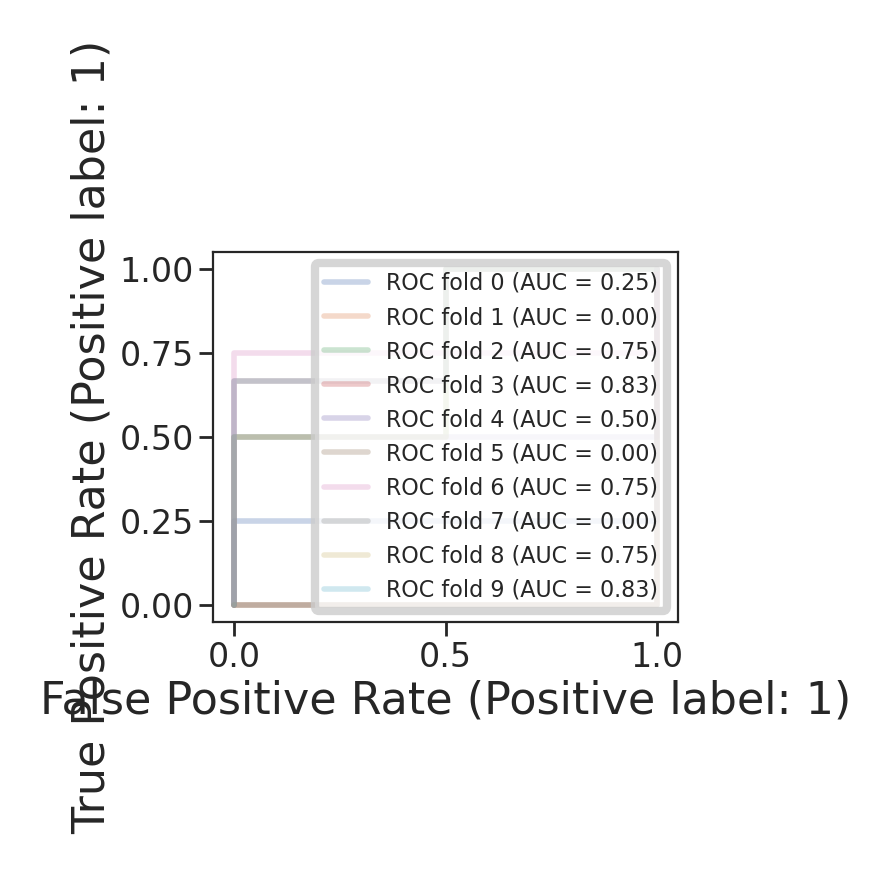

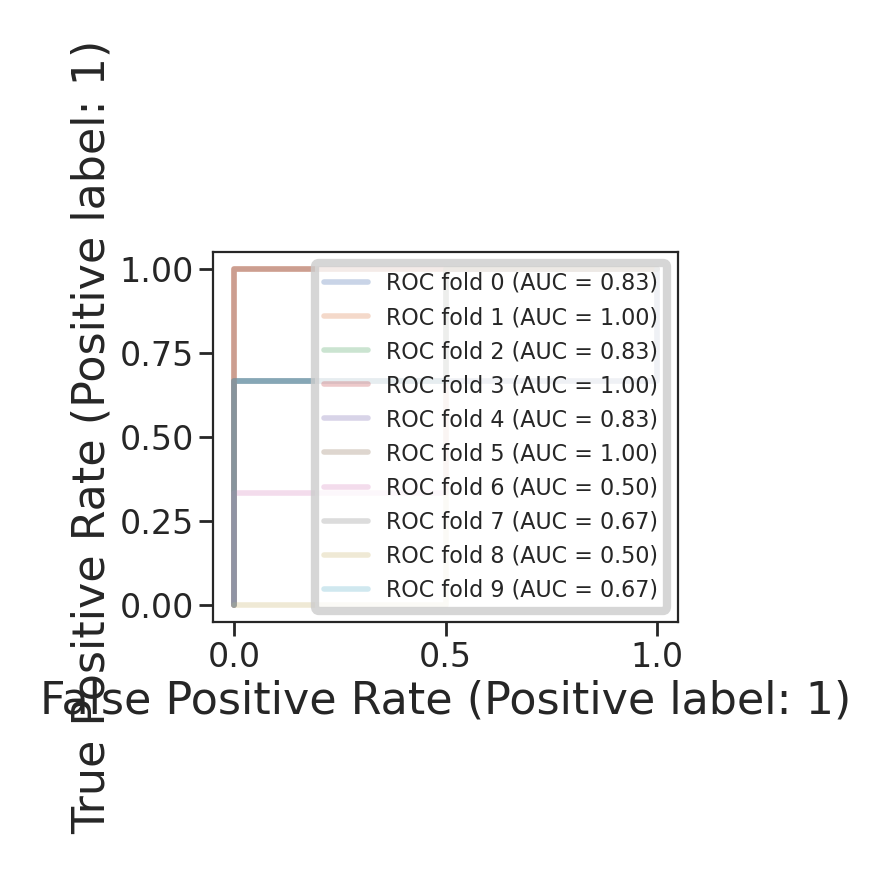

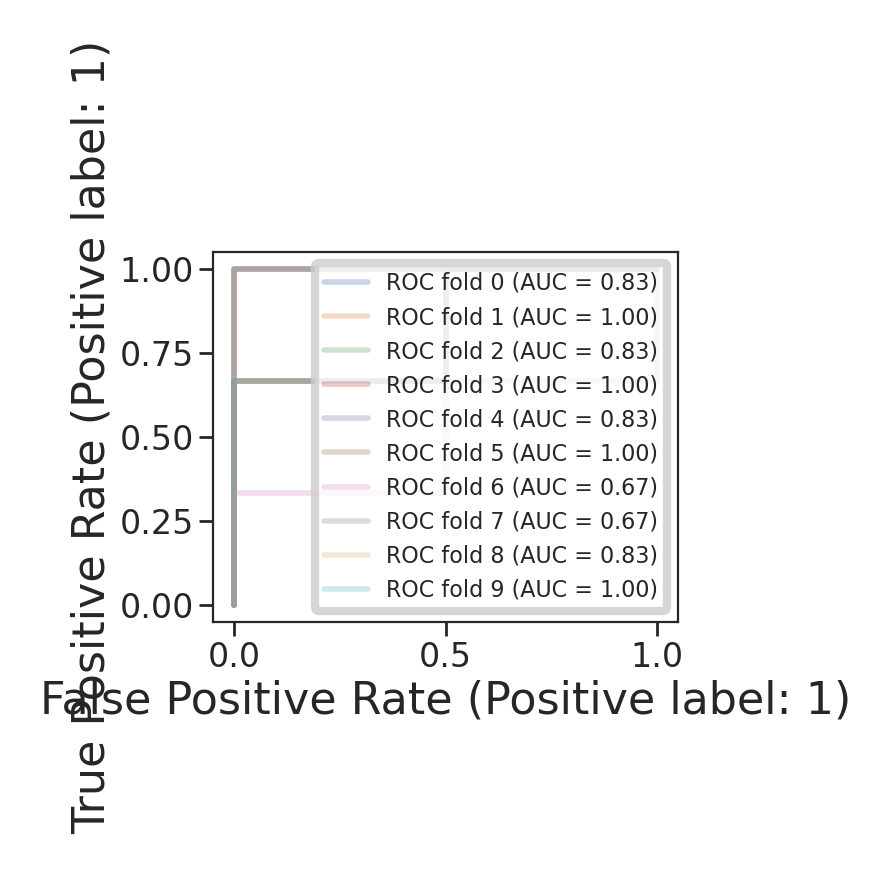

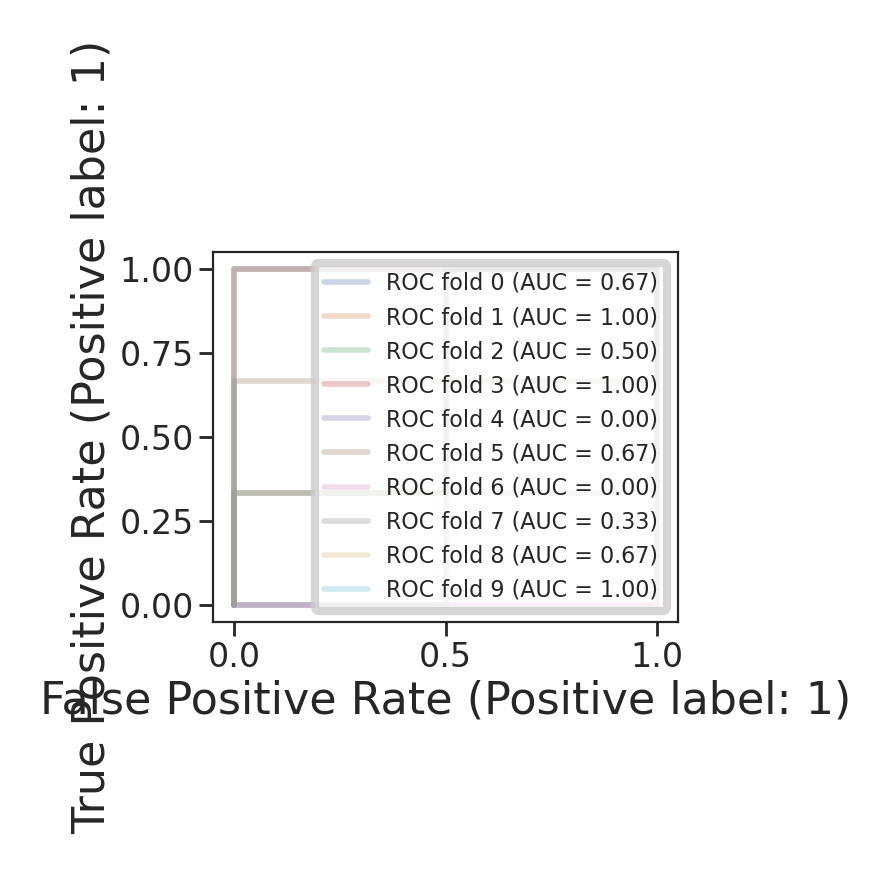

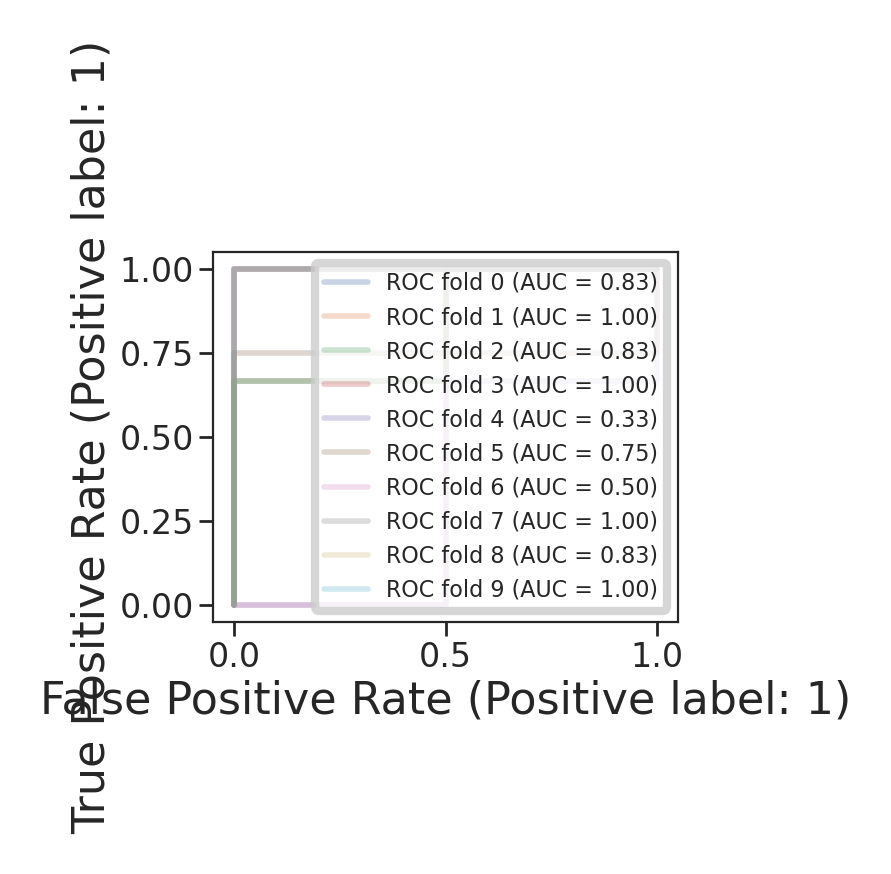

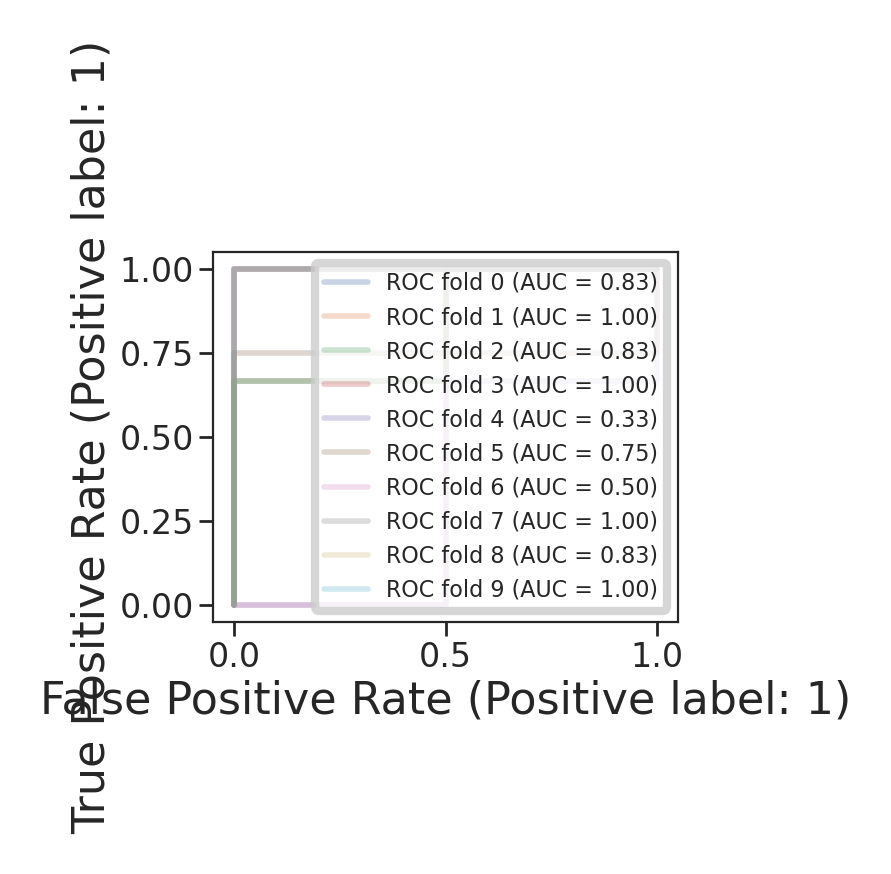

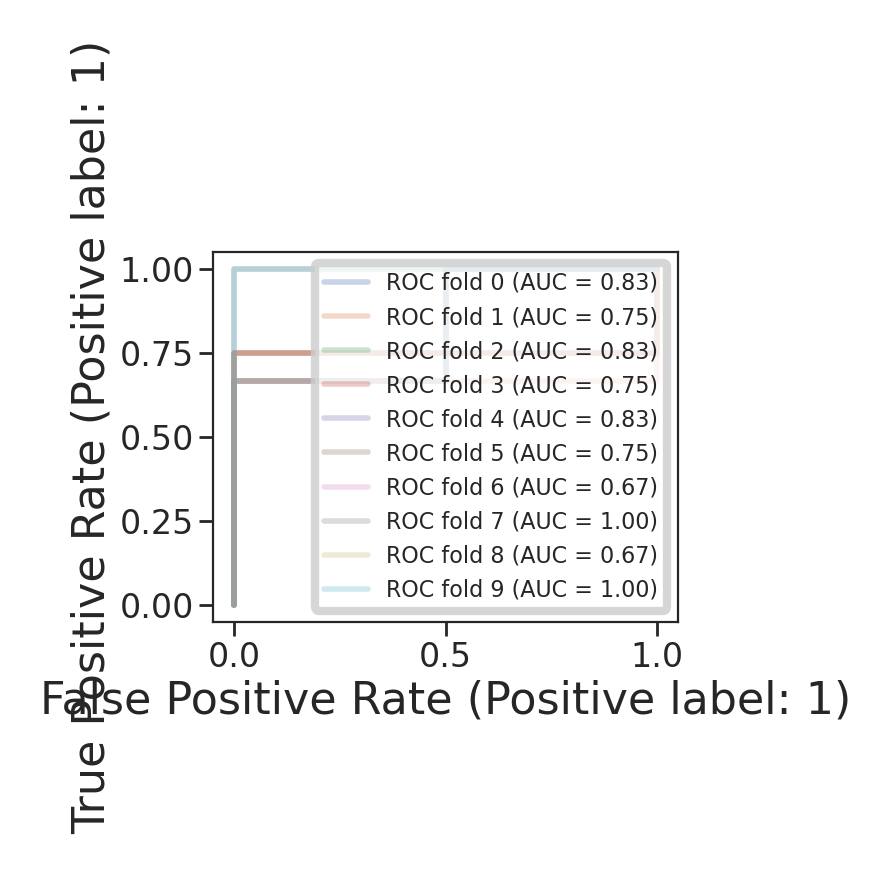

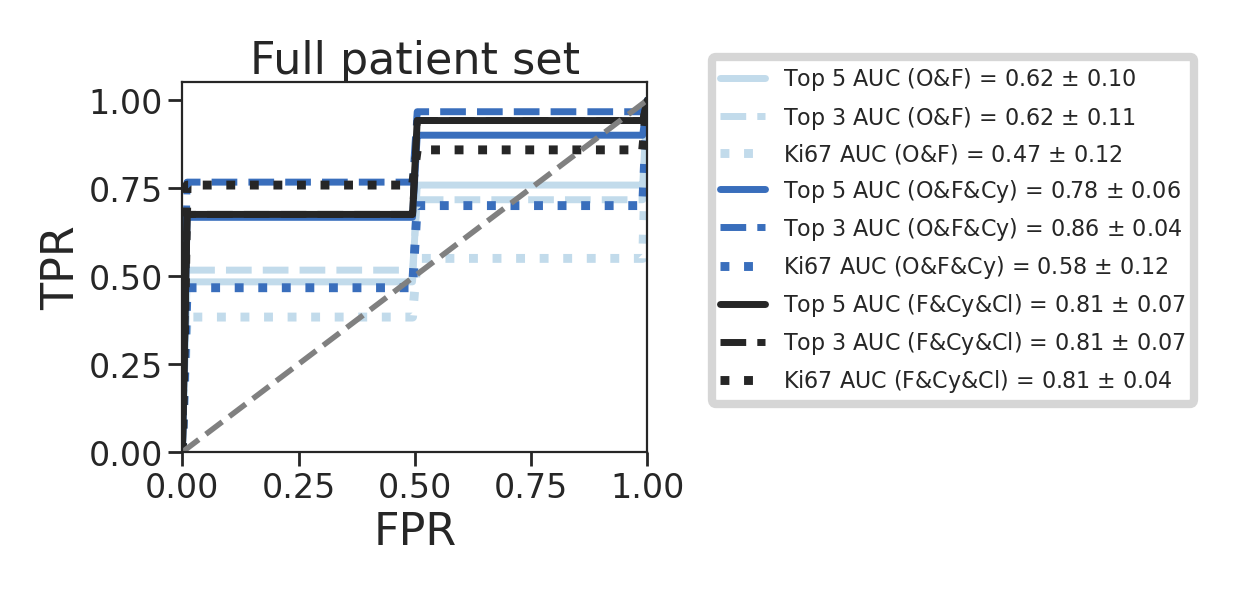

In [14]:
selected_patients = ['P1.1', 'P105.1', 'P141.1', 'P15.1', 'P17.1', 'P22.1', 'P27.1', 'P28.1', 'P37.1', 'P4.1', 'P5.1', 'P7.1', 'P8.1', 'P90.1', 'P92.1']

# Olink FACS

# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc]]

selected_features2 = ["Ki67_FACS", "CXCR3_FACS", "IL4_FACS", "B7_FACS", "TNF"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model1, mean_tpr_model1, mean_auc_model1, std_auc_model1 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")
# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


selected_features3 = ["Ki67_FACS", "CXCR3_FACS", "IL4_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model1_less, mean_tpr_model1_less, mean_auc_model1_less, std_auc_model1_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")
# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


selected_features4 = ["Ki67_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=32)
train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model_1ki, mean_tpr_model_1ki, mean_auc_model_1ki, std_auc_model_1ki =get_input_data(data=train,
                                                                                what2choose=selected_features4,
                                                                                   treatment_or_response="response")
# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


# Olink FACS CyTOF
# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, olinikiloc, cytof_freiloc]]
selected_features2 = ["Ki67_FACS", "CXCR3_FACS", "GPR15_FACS", "CXCL6", "IL4_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model2, mean_tpr_model2, mean_auc_model2, std_auc_model2 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")
# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


selected_features3 = ["Ki67_FACS", "CXCR3_FACS", "GPR15_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model2_less, mean_tpr_model2_less, mean_auc_model2_less, std_auc_model2_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")
# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


selected_features4 = ["Ki67_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=35)
train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model_2ki, mean_tpr_model_2ki, mean_auc_model_2ki, std_auc_model_2ki =get_input_data(data=train,
                                                                                what2choose=selected_features4,
                                                                                   treatment_or_response="response")

# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


# Clinical FACS CyTOF
# -----------------------------------------------------------------------------------------------------
contrast_data = only_timepoint_one_filtered.iloc[:, np.r_[facsiloc, clinicaliloc, cytof_freiloc]]
selected_features2 = ["NK cells", "CXCR3_FACS", "Ki67_FACS", "IFNg_FACS", "CD103_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model3, mean_tpr_model3, mean_auc_model3, std_auc_model3 = get_input_data(data=train,
                                                                                   what2choose=selected_features2,
                                                                                   treatment_or_response="response")

# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


selected_features3 = ["NK cells", "CXCR3_FACS", "Ki67_FACS", "IFNg_FACS", "CD103_FACS"]
contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
train = train.loc[train.index.intersection(selected_patients)]
train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model3_less, mean_tpr_model3_less, mean_auc_model3_less, std_auc_model3_less = get_input_data(data=train,
                                                                                                       what2choose=selected_features3,
                                                                                                       treatment_or_response="response")

# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


selected_features4 = ["Ki67_FACS"]

contrast_data['Response'] = only_timepoint_one_filtered['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
train, test = train_test_split(contrast_data, test_size=0.2, stratify=contrast_data['Response'], random_state=0)
train = train.loc[train.index.intersection(selected_patients)]

train = train[selected_features2 + ['Response']]
test = test[selected_features2 + ['Response']]
print(test)
mean_fpr_model_3ki, mean_tpr_model_3ki, mean_auc_model_3ki, std_auc_model_3ki =get_input_data(data=train,
                                                                                what2choose=selected_features4,
                                                                                   treatment_or_response="response")

# Check test data set
contrast_data['Response_bin'] = np.where(contrast_data['Response'] == "R", 1, 0)
contrast_data = contrast_data.drop(columns='Response')
X = contrast_data.drop('Response_bin', axis=1)
X_test = X[X.index.isin(test.index)]
X_train = X[X.index.isin(train.index)]
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)
X_test_scaler = scaler.transform(X_test)
y = contrast_data.Response_bin
y_train = y[y.index.isin(train.index)]
y_test = y[y.index.isin(test.index)]
print(y_test)
# Retrain training data on top 10% -------------------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaler, y_train)
# Predict on test set -------------------------------------------------------------------------------------
y_pred = logreg.predict(X_test_scaler)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" + str(accuracy))


# -----------------------------------------------------------------------------------------------------
plt.figure()
plt.rcParams['figure.dpi'] = 400
lw = 1.25
plt.plot(mean_fpr_model1, mean_tpr_model1,
         label=r"Top 5 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model1, std_auc_model1),
         color="#c2dbebff", lw=lw)
plt.plot(mean_fpr_model1_less, mean_tpr_model1_less,
         label=r"Top 3 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model1_less, std_auc_model1_less),
         color="#c2dbebff", lw=lw, linestyle='--')

plt.plot(mean_fpr_model_1ki, mean_tpr_model_1ki,
         label=r"Ki67 AUC (O&F) = %0.2f $\pm$ %0.2f" % (mean_auc_model_1ki, std_auc_model_1ki),
         color="#c2dbebff", lw=1.6, linestyle='dotted')


plt.plot(mean_fpr_model2, mean_tpr_model2,
         label=r"Top 5 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model2, std_auc_model2),
         color="#396ebcff", lw=lw)
plt.plot(mean_fpr_model2_less, mean_tpr_model2_less,
         label=r"Top 3 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model2_less, std_auc_model2_less),
         color="#396ebcff", lw=lw, linestyle='--')

plt.plot(mean_fpr_model_2ki, mean_tpr_model_2ki,
         label=r"Ki67 AUC (O&F&Cy) = %0.2f $\pm$ %0.2f" % (mean_auc_model_2ki, std_auc_model_2ki),
         color="#396ebcff", lw=1.6, linestyle='dotted')

plt.plot(mean_fpr_model3, mean_tpr_model3,
         label=r"Top 5 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model3, std_auc_model3),
         color="#262626ff", lw=lw)
plt.plot(mean_fpr_model3_less, mean_tpr_model3_less,
         label=r"Top 3 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model3_less, std_auc_model3_less),
         color="#262626ff", lw=lw, linestyle='--')

plt.plot(mean_fpr_model_3ki, mean_tpr_model_3ki,
         label=r"Ki67 AUC (F&Cy&Cl) = %0.2f $\pm$ %0.2f" % (mean_auc_model_3ki, std_auc_model_3ki),
         color="#262626ff", lw=1.6, linestyle='dotted')



plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Full patient set")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')
#plt.savefig('Full_patients_3Models.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# External validation cohort

In [ ]:
metadata = pd.read_csv(
    "../External_ValidationCohort.csv", sep=';',
    index_col=0, decimal=',')
only_timepoint_one = metadata[metadata["timepoint"] == 1]
only_timepoint_one = only_timepoint_one[
    (only_timepoint_one["response"] == "R") | (only_timepoint_one["response"] == "NR")]


selected_features = ['CD4mem_Ki67_FACS']
contrast_data = only_timepoint_one[selected_features]

contrast_data['Response'] = only_timepoint_one['response']
contrast_data.dropna(axis=0, how='any', inplace=True)

mean_fpr_facs, mean_tpr_facs, mean_auc_facs, std_auc_facs = get_input_data(data=contrast_data,
                                                                           what2choose=selected_features,
                                                                           treatment_or_response="response")

selected_features = ["CD4mem_Ki67_FACS","CD4mem_CXCR3_FACS","CD4mem_IL4_FACS"]
contrast_data = only_timepoint_one[selected_features]

contrast_data['Response'] = only_timepoint_one['response']
contrast_data.dropna(axis=0, how='any', inplace=True)
mean_fpr_facs3, mean_tpr_facs3, mean_auc_facs3, std_auc_facs3 = get_input_data(data=contrast_data,
                                                                               what2choose=selected_features,
                                                                               treatment_or_response="response")



fig, ax = plt.subplots()
plt.figure()
lw = 1.25
plt.plot(mean_fpr_facs, mean_tpr_facs,
         label=r"only Ki67 AUC= %0.2f $\pm$ %0.2f" % (mean_auc_facs, std_auc_facs),
         color="#efa451", lw=lw)

plt.plot(mean_fpr_facs3, mean_tpr_facs3,
         label=r"Top 3 FACS AUC = %0.2f $\pm$ %0.2f" % (mean_auc_facs3, std_auc_facs3),
         color="#d95f0e", lw=lw)

plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("External validation cohort")
plt.legend(bbox_to_anchor=(2.2, 0.6), loc='center right')

plt.savefig('AUC_Validation.pdf', bbox_inches='tight', format='pdf')

plt.show()